In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import numpy as np


In [4]:
import pandas as pd

emicron = pd.read_csv("/content/drive/MyDrive/Colab_Notebooks/Final_Project/Data/emicron_clean.csv")  # Include the subdirectory in the file path

In [5]:
#dropping EXP FACTOR
emicron.drop(['F_EXP'], axis=1, inplace=True)

#checking if PCA is appropriate

*correlation among variables*

In [ ]:
emicron.shape

(80753, 140)

<ipython-input-13-a3030f8773a2>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = emicron.corr()


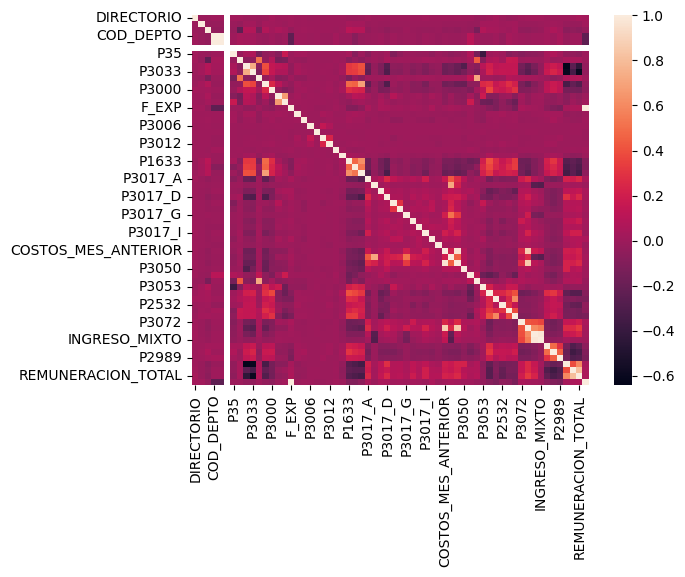

In [ ]:
# Assuming df is your DataFrame
correlation_matrix = emicron.corr()

import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(correlation_matrix)
plt.show()


*variance*

In [ ]:
# Variance
variance = emicron.var()

# Standard deviation
std_dev = emicron.std()

print("Variance:\n", variance)
print("Standard Deviation:\n", std_dev)

Variance:
 DIRECTORIO            2.227883e+12
SECUENCIA_P           2.577726e-02
SECUENCIA_ENCUESTA    1.301317e+00
COD_DEPTO             6.063780e+02
AREA                  6.063780e+02
                          ...     
P2989                 1.747034e-02
P3091                 7.838626e-01
PRESTACIONES          1.916944e+11
REMUNERACION_TOTAL    1.133795e+12
FEX_MICRO_DPTO        3.796538e+03
Length: 62, dtype: float64
Standard Deviation:
 DIRECTORIO            1.492609e+06
SECUENCIA_P           1.605530e-01
SECUENCIA_ENCUESTA    1.140753e+00
COD_DEPTO             2.462474e+01
AREA                  2.462474e+01
                          ...     
P2989                 1.321754e-01
P3091                 8.853602e-01
PRESTACIONES          4.378292e+05
REMUNERACION_TOTAL    1.064798e+06
FEX_MICRO_DPTO        6.161605e+01
Length: 62, dtype: float64


<ipython-input-17-518fedcf7ce0>:2: FutureWarning: The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  variance = emicron.var()
<ipython-input-17-518fedcf7ce0>:5: FutureWarning: The default value of numeric_only in DataFrame.std is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  std_dev = emicron.std()


#Remove non-numeric columns, scale and apply PCA

In [6]:
from sklearn.preprocessing import StandardScaler

# Filter columns based on data types
numeric_columns = emicron.select_dtypes(include=['int64', 'float64'])

# Create a new DataFrame with only numeric columns
emicron = emicron[numeric_columns.columns]

# Now you can scale the data
scaler = StandardScaler()
X = scaler.fit_transform(emicron)

In [7]:
from sklearn.decomposition import PCA

# Apply PCA and keep only the top components

pca = PCA(n_components=90)

X = pca.fit_transform(X)

In [8]:
X.shape

(80753, 90)

In [ ]:
import matplotlib.pyplot as plt

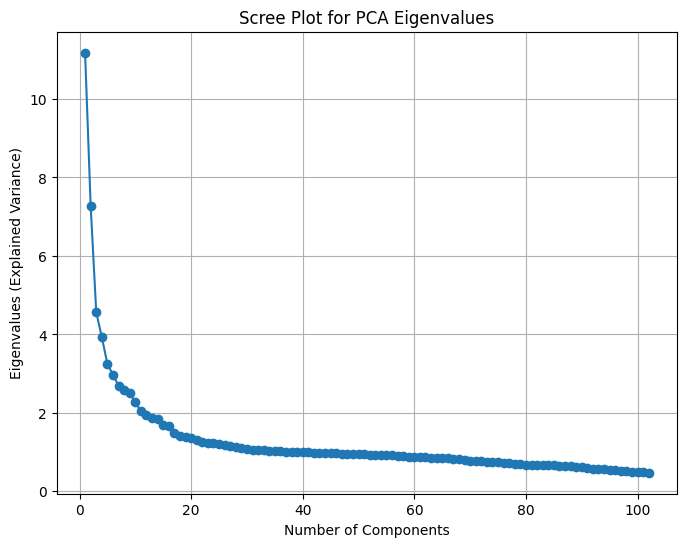

In [ ]:
# Plot eigenvalues (explained variance)
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_) + 1), pca.explained_variance_, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Eigenvalues (Explained Variance)')
plt.title('Scree Plot for PCA Eigenvalues')
plt.grid(True)
plt.show()

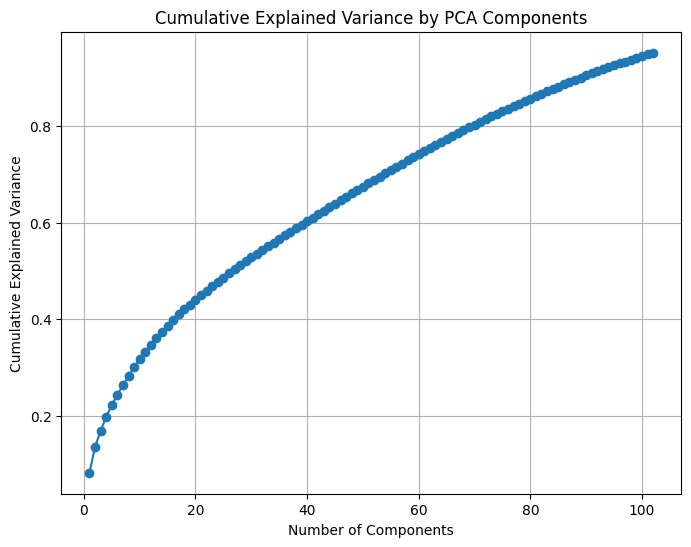

In [ ]:
# Plot cumulative explained variance
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.grid(True)
plt.show()


#PCA analysis with 2 components

In [ ]:
from sklearn.decomposition import PCA
# Create a PCA object
pca = PCA(n_components=2)
# Fit this to our data
emicron_pca = pca.fit_transform(X)

In [ ]:
emicron_pca.shape

(85862, 2)

In [ ]:
# Examining the first 5 rows of the principal components.
emicron_pca[:5,]

array([[-1.46496554, -0.34565828],
       [-1.78156699, -0.54723806],
       [-1.38844226, -1.20006038],
       [-2.04995591,  4.27667977],
       [-0.83482428, -1.15897736]])

In [ ]:
# Saving the principal components as a DataFrame
pca_df = pd.DataFrame(
    emicron_pca,
    index=emicron.index,
    columns=['Z1', 'Z2']
)
pca_df

In [ ]:
# Combining these into a Data Frame
pca_factor_weights = pd.DataFrame(
    pca.components_,
    columns=emicron.columns
).transpose().rename({0:'Z1', 1:'Z2'}, axis=1)
# Visualizing our DataFrame
pca_factor_weights

,Z1,Z2
DIRECTORIO,0.006596,0.001140
SECUENCIA_P,-0.011574,-0.011932
SECUENCIA_ENCUESTA,-0.041979,-0.088271
COD_DEPTO,-0.001992,-0.008248
CLASE_TE,-0.057112,0.278420
P35,-0.011631,-0.165070
P241,-0.000609,0.207893
P3031,-0.201650,-0.161618
P3033,-0.221326,-0.145839
P3034,0.004735,0.264288


In [ ]:
pca_factor_weights.Z1.sort_values(key=abs, ascending=False)

REMUNERACION_TOTAL     0.255408
P1055                 -0.240489
VENTAS_MES_ANTERIOR    0.238193
P1633                 -0.231993
P640                  -0.227640
P3091                  0.222074
P3033                 -0.221326
CONSUMO_INTERMEDIO     0.215394
P3035                 -0.210629
PRESTACIONES           0.209038
P3031                 -0.201650
P4001                 -0.200217
COSTOS_MES_ANTERIOR    0.192473
P3090                 -0.175745
P2524                 -0.164251
P3072                  0.161442
P3017_A                0.160860
P3017_D                0.155932
GASTOS_MES             0.155774
P3000                 -0.144285
P1559                 -0.136672
P976                  -0.130979
P2989                 -0.130931
P3088                 -0.130896
VALOR_AGREGADO         0.129336
P2532                 -0.118821
P3017_C                0.113400
P3017_I                0.103120
P3017_H                0.081203
INGRESO_MIXTO          0.077243
P3053                 -0.073866
P3050   

In [ ]:
pca_factor_weights.Z2.sort_values(key=abs, ascending=False)

GRUPOS12              -0.362602
GRUPOS4               -0.346552
CLASE_TE               0.278420
P3053                  0.269624
P3034                  0.264288
P2524                  0.248018
P639                   0.223675
P241                   0.207893
P1559                  0.181471
P976                   0.177406
P35                   -0.165070
P4001                  0.164432
P3031                 -0.161618
P3091                  0.154698
P3033                 -0.145839
VENTAS_MES_ANTERIOR    0.137675
P3000                  0.132392
CONSUMO_INTERMEDIO     0.129062
COSTOS_MES_ANTERIOR    0.127148
P3050                  0.109203
FEX_MICRO_DPTO         0.100509
REMUNERACION_TOTAL     0.098687
P3002                 -0.097464
SECUENCIA_ENCUESTA    -0.088271
P640                   0.085102
P1633                  0.082896
P3051                 -0.072677
P3006                 -0.070640
VALOR_AGREGADO         0.067653
P3017_C               -0.066992
P3004                 -0.062924
P2532   

In [ ]:
# Reporting the marginal variance explained.
pca.explained_variance_ratio_

array([0.11632286, 0.06078648])

In [ ]:
# Calculating the cumulative variance explained
np.cumsum(pca.explained_variance_ratio_)

array([0.11632286, 0.17710934])

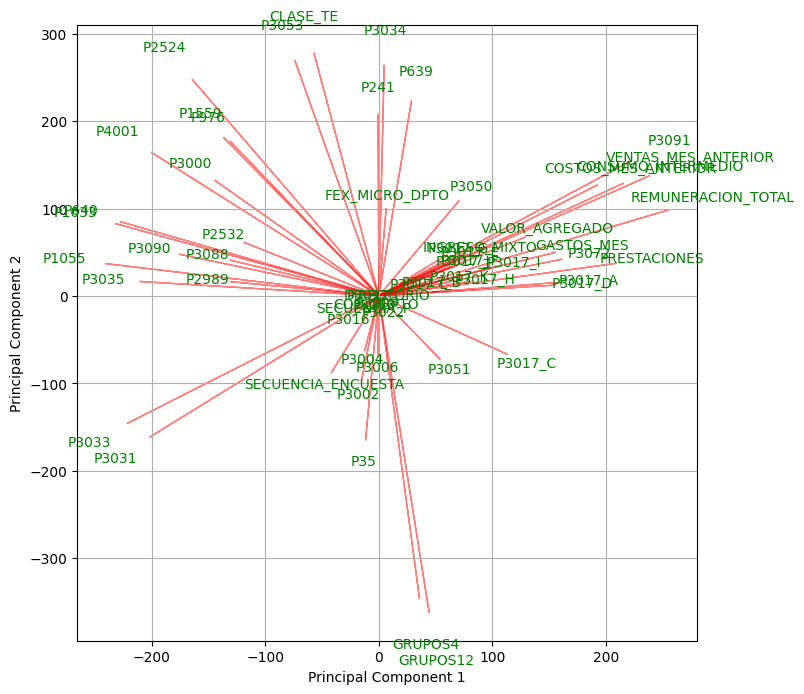

In [ ]:
import matplotlib.pyplot as plt


# Create the biplot
plt.figure(figsize=(8, 8))
plt.scatter(emicron_pca[:, 0], emicron_pca[:, 1], alpha=0.0)

# Plot arrows representing feature loadings
factor_scale = 1000
for i, (component1, component2) in enumerate(zip(pca.components_[0], pca.components_[1])):
    plt.arrow(0, 0, component1*factor_scale, component2*factor_scale, color='r', alpha=0.5, width=0.01)
    plt.text(component1*1.15*factor_scale, component2*1.15*factor_scale, emicron.columns[i], color='g', ha='center', va='center', fontsize=10)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

In [ ]:
pip install pca

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.3/51.3 kB 2.1 MB/s eta 0:00:00


In [ ]:
from pca import pca as pca2

In [ ]:
model = pca2()

results = model.fit_transform(X, col_labels=emicron.columns, row_labels=emicron.index)

[pca] >Column labels are auto-completed.
[pca] >The PCA reduction is performed to capture [95.0%] explained variance using the [102] columns of the input data.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Compute explained variance.
[pca] >Number of components is [90] that covers the [95.00%] explained variance.
[pca] >The PCA reduction is performed on the [102] columns of the input dataframe.
[pca] >Fit using PCA.
[pca] >Compute loadings and PCs.
[pca] >Outlier detection using Hotelling T2 test with alpha=[0.05] and n_components=[90]
[pca] >Multiple test correction applied for Hotelling T2 test: [fdr_bh]
[pca] >Outlier detection using SPE/DmodX with n_std=[3]


(<Figure size 1500x1000 with 1 Axes>,
 <Axes: title={'center': 'Cumulative explained variance\n 90 Principal Components explain [95.51%] of the variance.'}, xlabel='Principle Component', ylabel='Percentage explained variance'>)

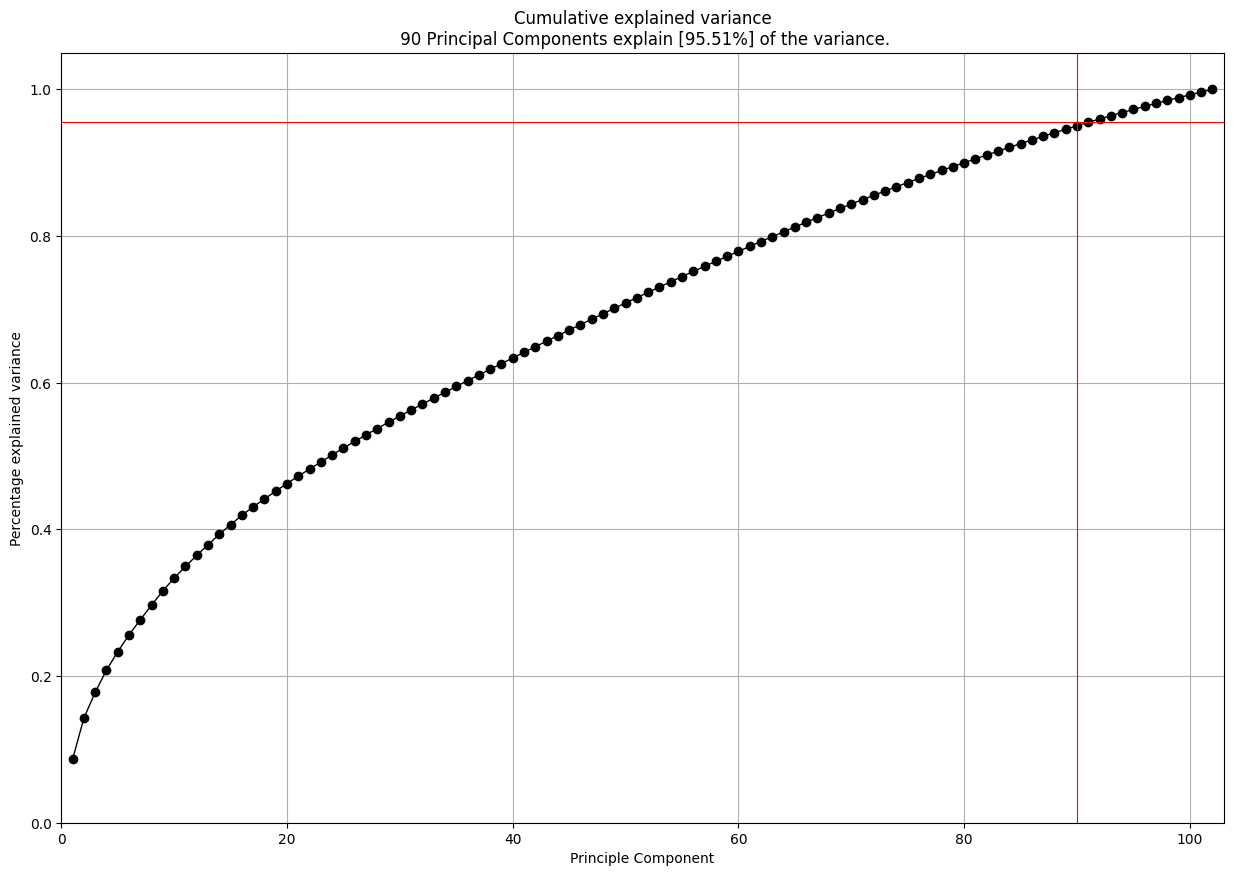

In [ ]:
model.plot()

[scatterd] >INFO> Create scatterplot


[pca] >Plot PC1 vs PC2 with loadings.


(<Figure size 2500x1500 with 1 Axes>,
 <Axes: title={'center': '90 Principal Components explain [95.51%] of the variance'}, xlabel='PC1 (8.63% expl.var)', ylabel='PC2 (5.61% expl.var)'>)

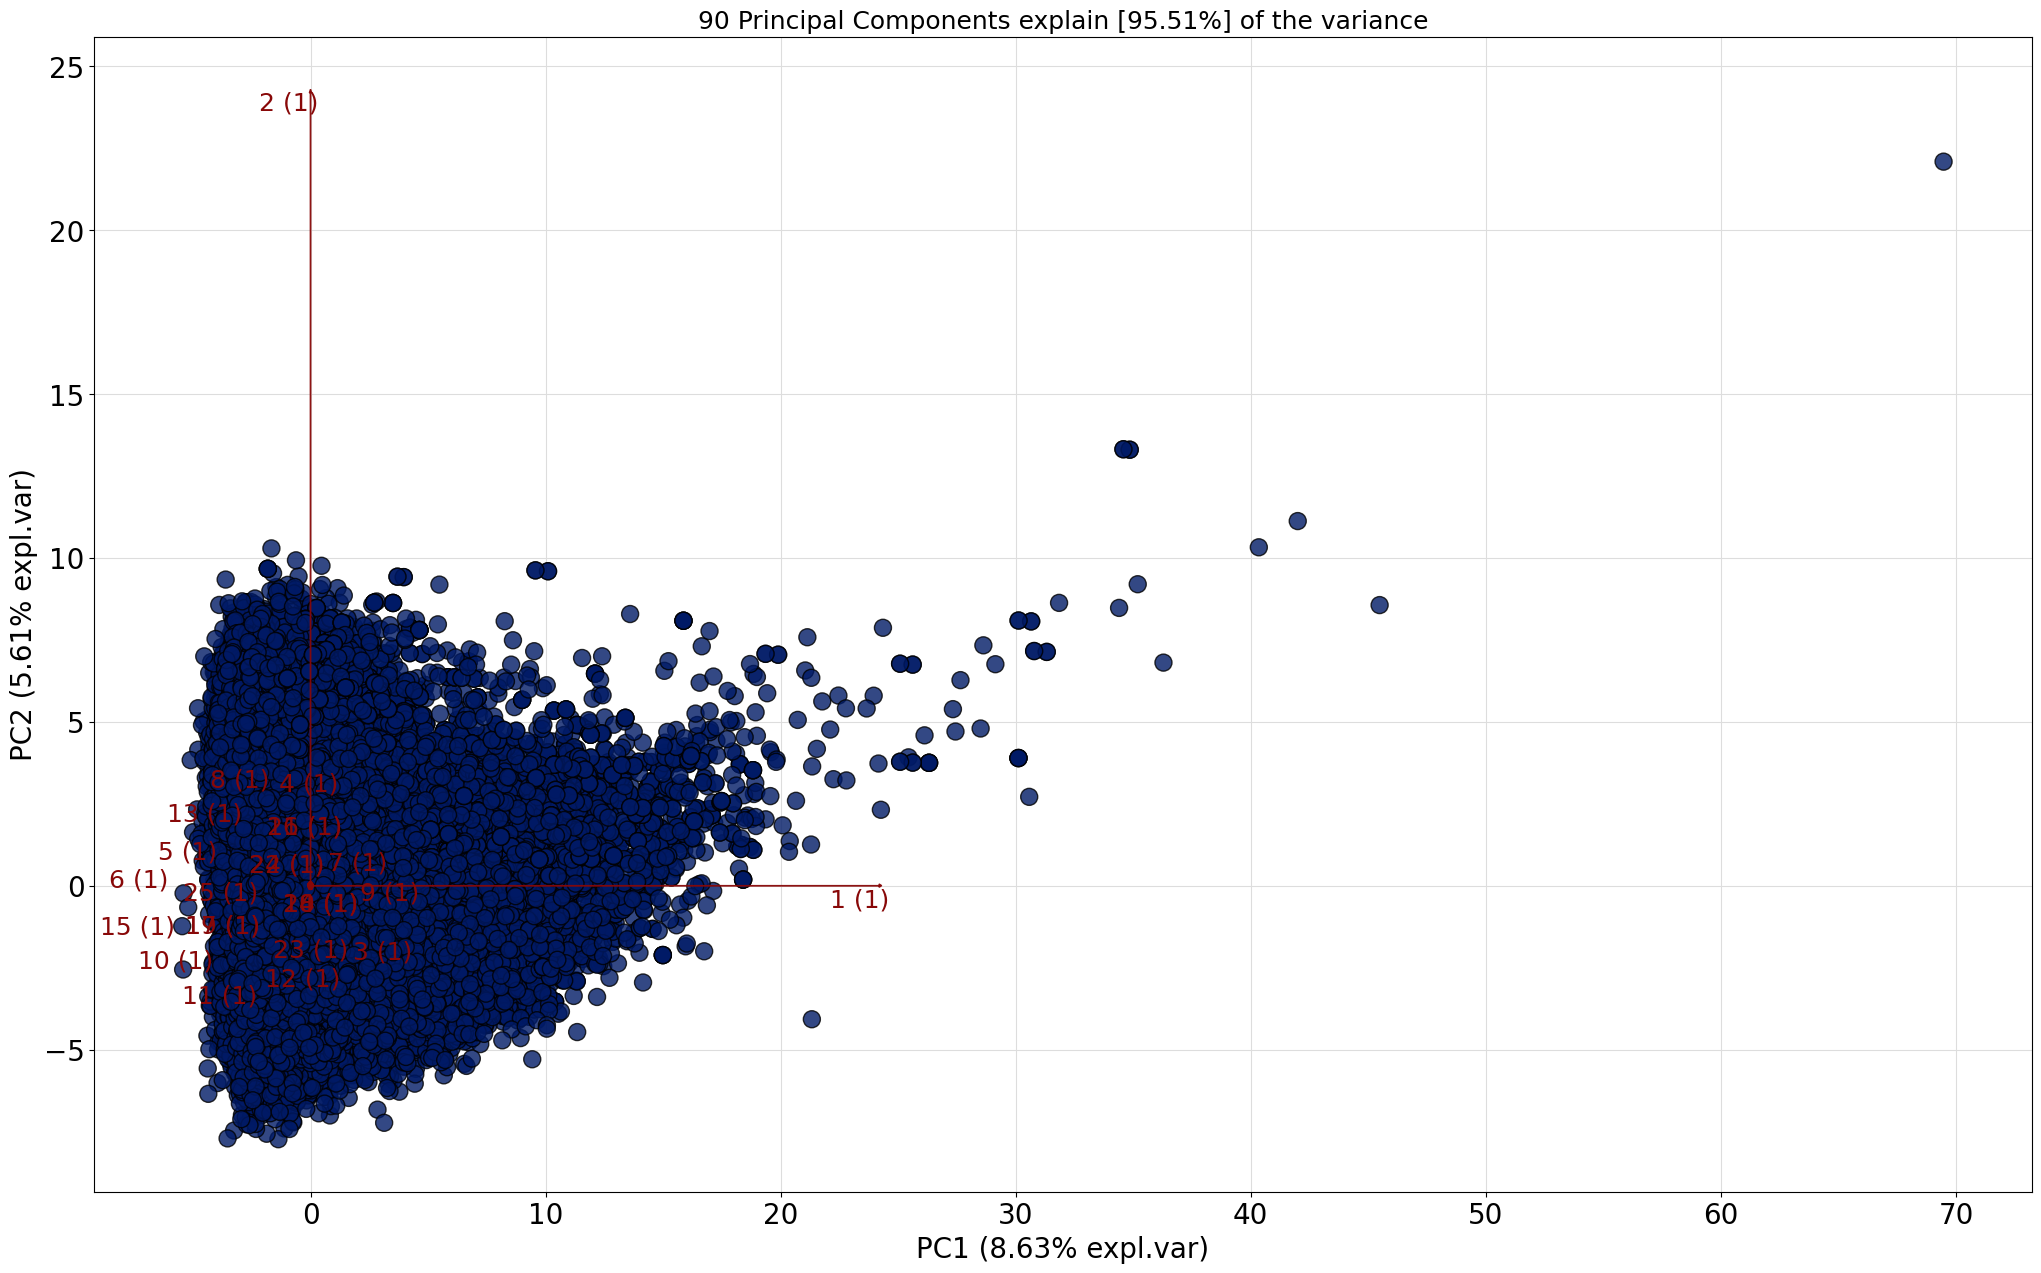

In [ ]:
model.biplot()

[scatterd] >INFO> Create scatterplot


[pca] >Plot PC1 vs PC2 with loadings.


(<Figure size 2500x1500 with 1 Axes>,
 <Axes: title={'center': '90 Principal Components explain [95.51%] of the variance'}, xlabel='PC1 (8.63% expl.var)', ylabel='PC2 (5.61% expl.var)'>)

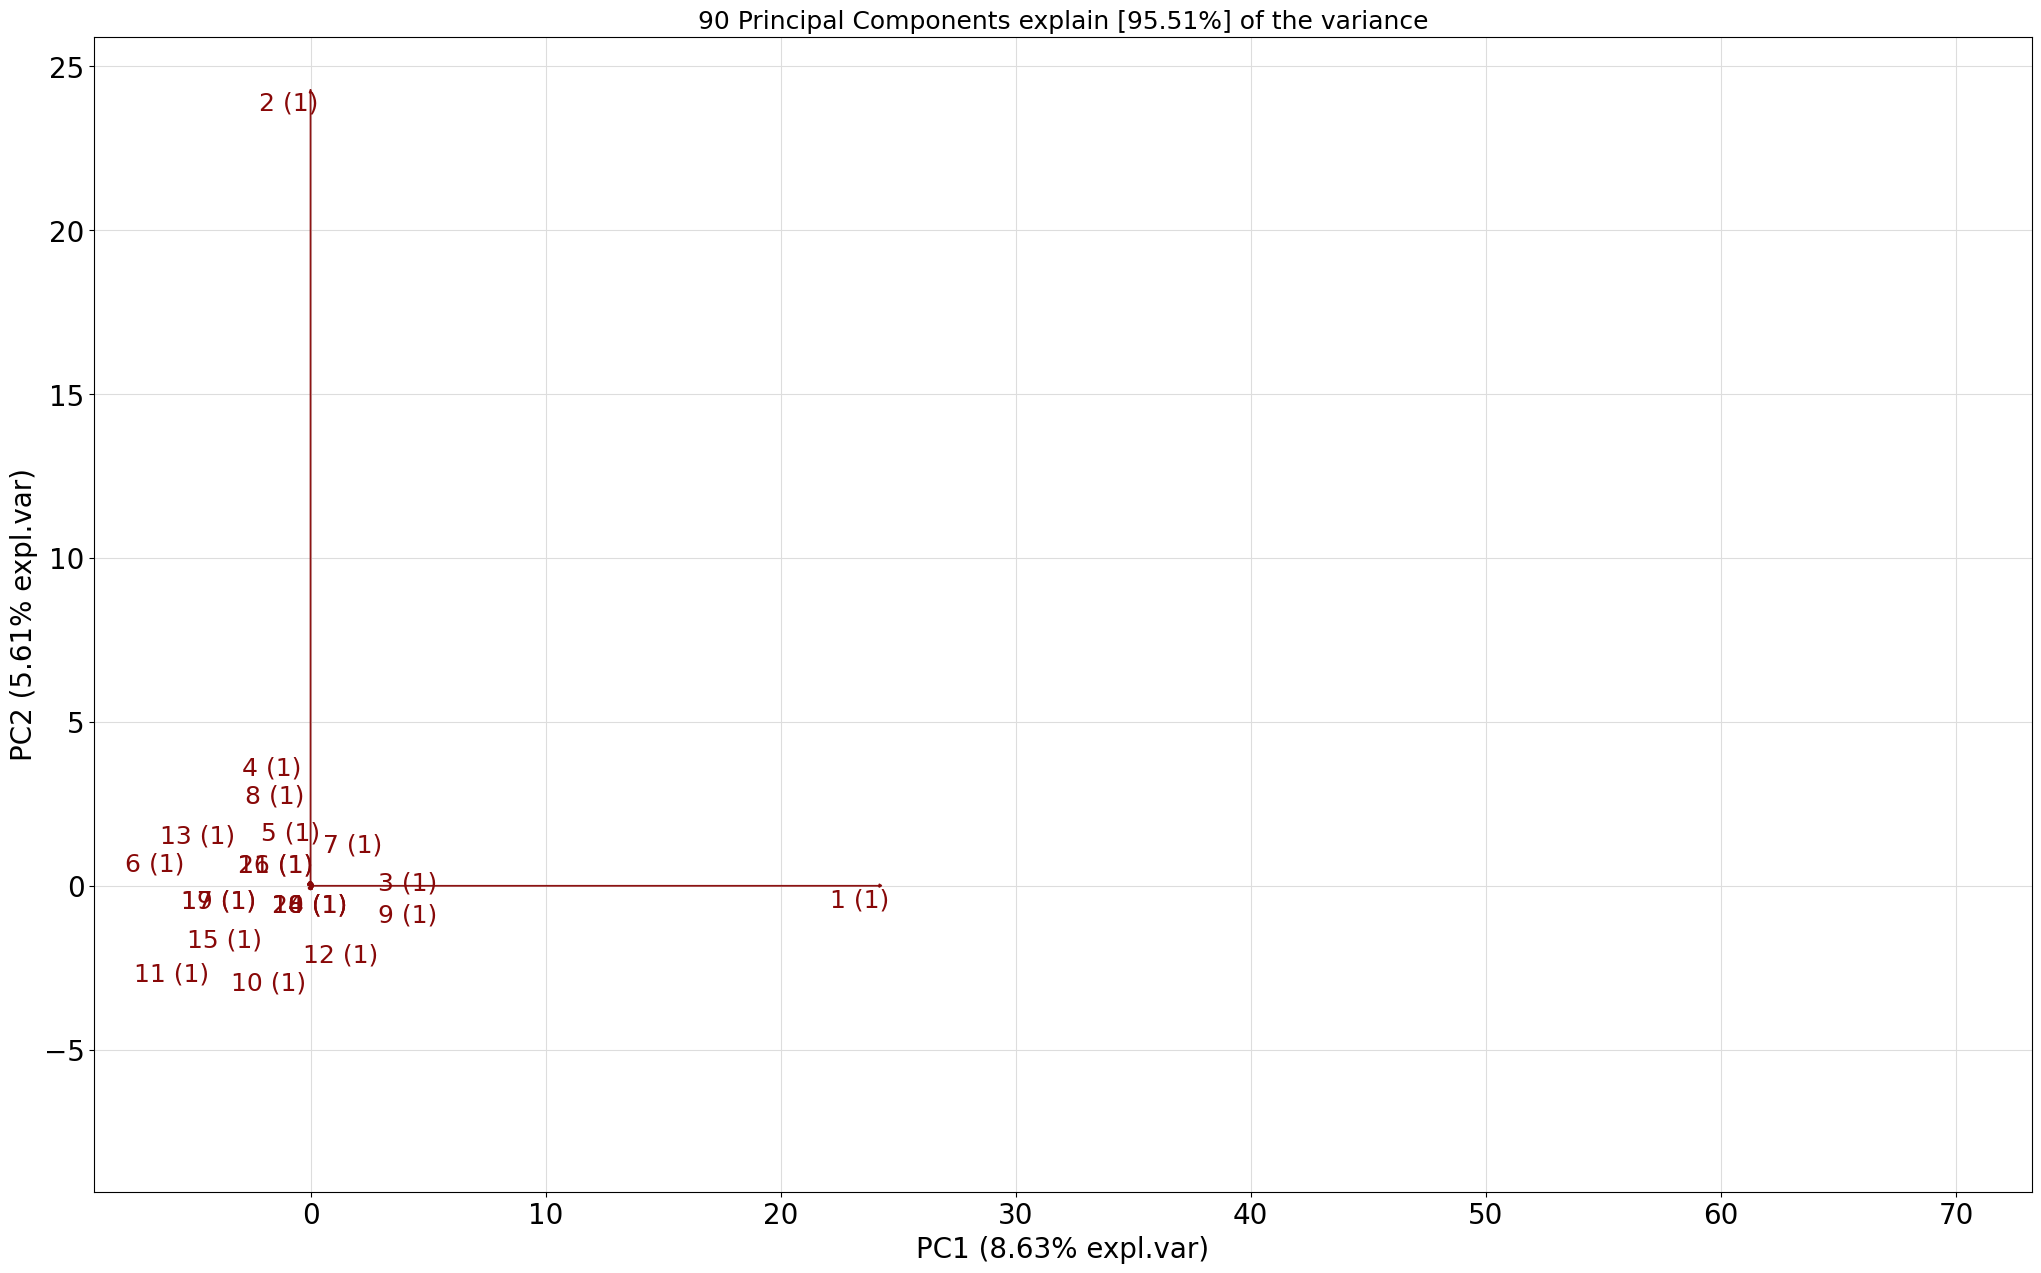

In [ ]:
# Plotting just the top 5 factor loadings
model.biplot(legend=False, cmap=None, n_feat=21)

[scatterd] >INFO> Create scatterplot


[pca] >Plot PC1 vs PC2 vs PC3 with loadings.


(<Figure size 3000x2500 with 1 Axes>,
 <Axes3D: title={'center': '90 Principal Components explain [95.51%] of the variance'}, xlabel='PC1 (8.63% expl.var)', ylabel='PC2 (5.61% expl.var)', zlabel='PC3 (3.52% expl.var)'>)

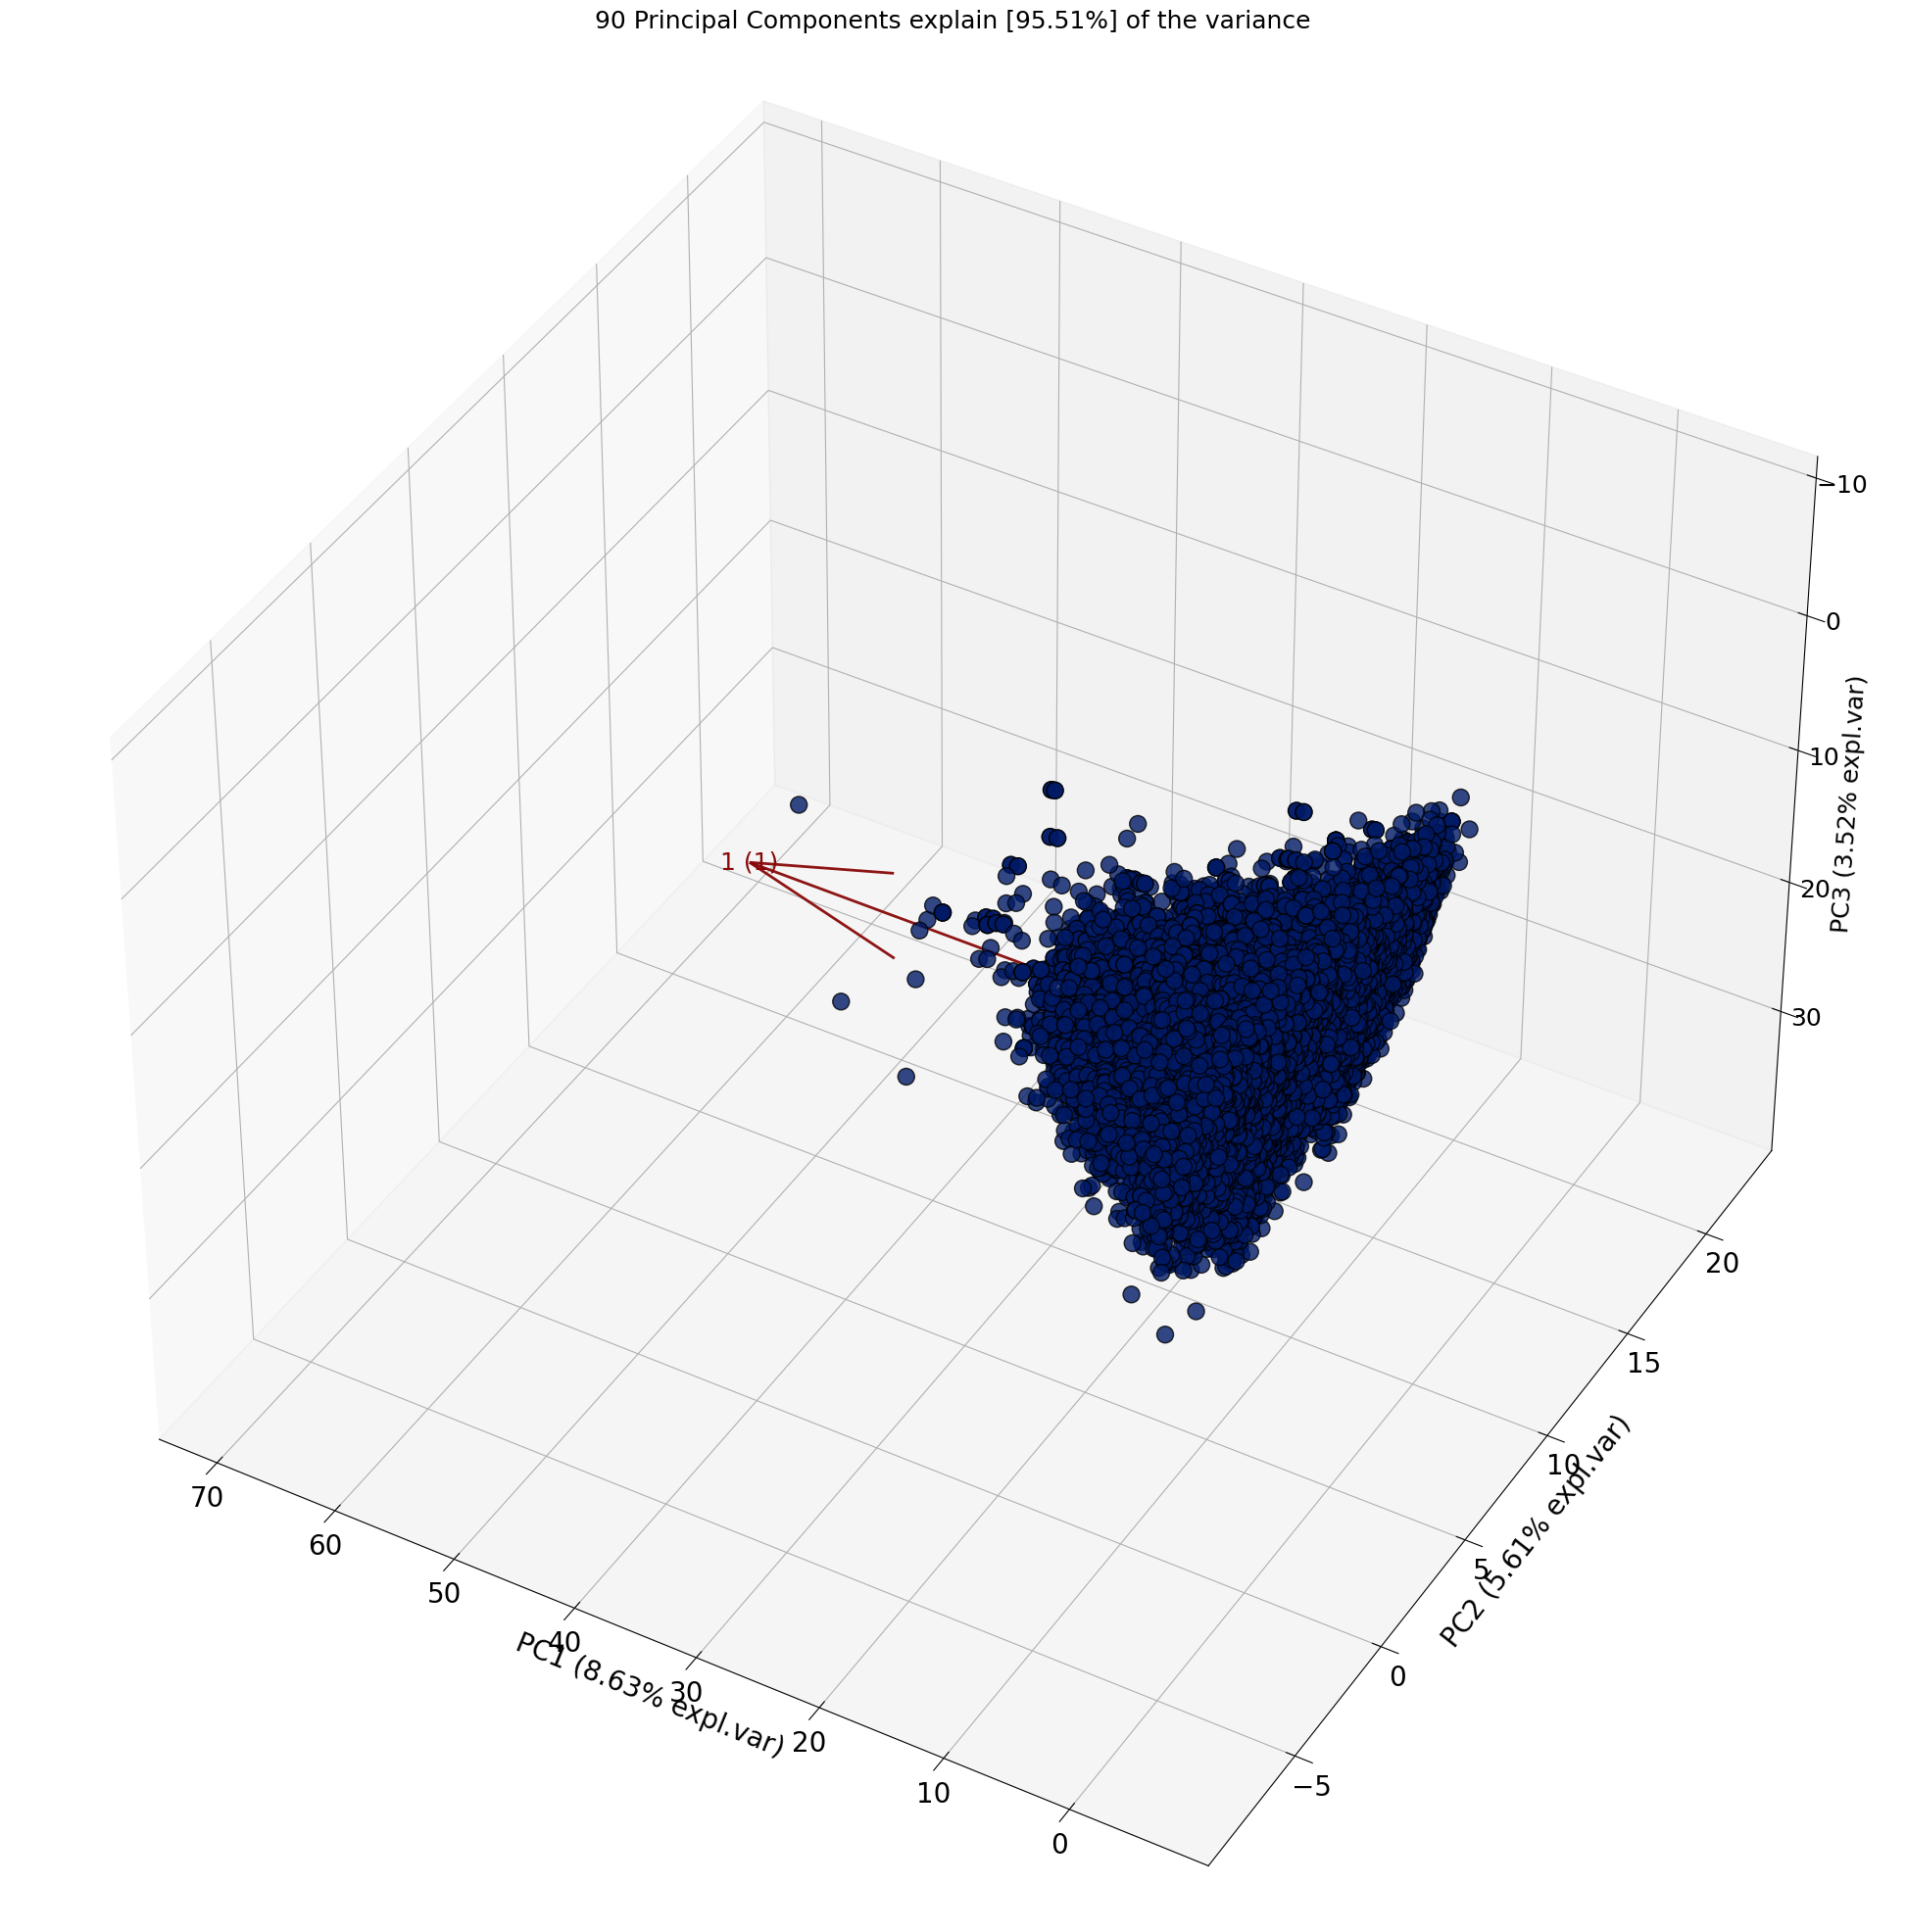

In [ ]:
model.biplot3d(n_feat=0)

#Models: HAC

In [ ]:
X_sample = X[(np.random.choice(X.shape[0], size=2000, replace=False))]

In [ ]:
from sklearn.cluster import AgglomerativeClustering

# Saving a shorter named object to use
HClust = AgglomerativeClustering

# Fitting a model
hc_comp = HClust(distance_threshold=0,
                 n_clusters=None,
                 linkage='ward')

# Fitting this to our data
hc_comp.fit(X_sample)

AgglomerativeClustering(distance_threshold=0, n_clusters=None)

In [ ]:
from scipy.cluster.hierarchy import dendrogram, linkage

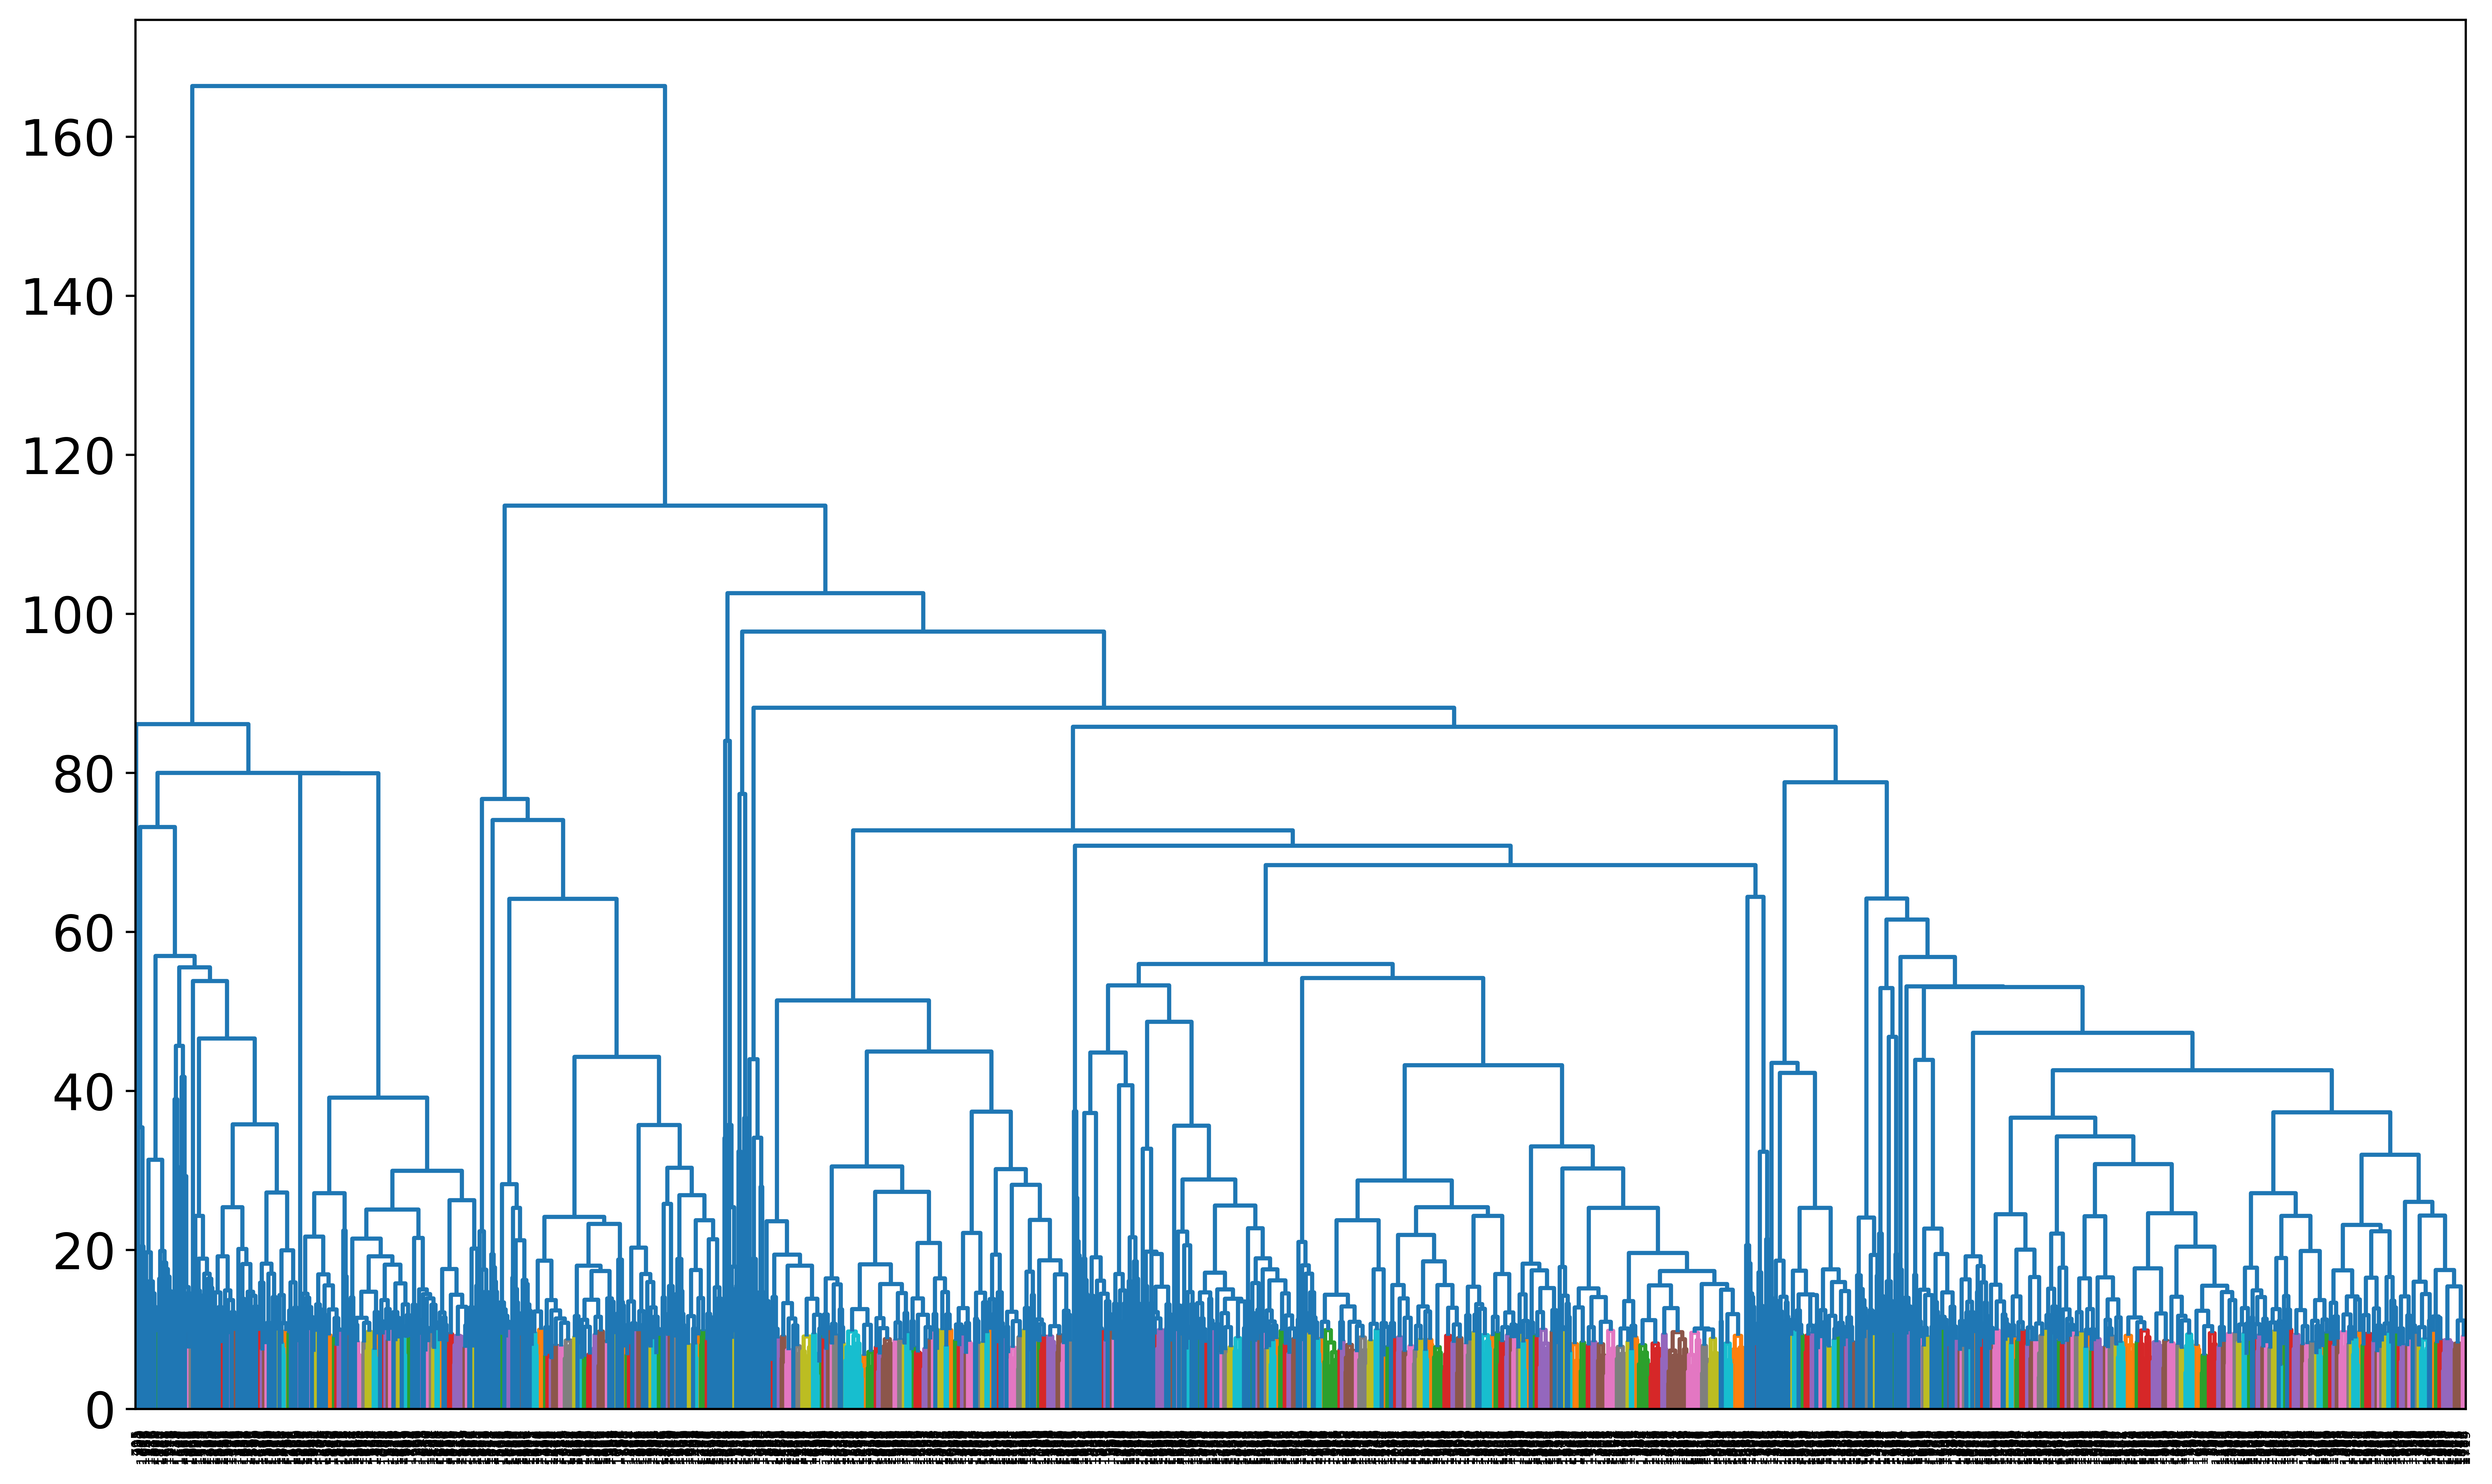

In [ ]:
# Create a linkage matrix using the scipy.cluster function, this calculates the order of the groups
Z = linkage(X_sample, method='ward')

color_threshold = 10  # Adjust the vertical threshold for assigning groups / clusters
plt.figure(figsize=(15, 9), dpi=600) # altering the figure size and resolution with dpi
dendrogram(Z, color_threshold=color_threshold)
# Rotate the x-axis labels for better readability
plt.xticks(rotation=90)
# Show the plot
plt.show()

In [ ]:
from sklearn.cluster import AgglomerativeClustering

# Saving a shorter named object to use
HClust = AgglomerativeClustering

# Fitting a model
hc_comp = HClust(distance_threshold=50,
                 n_clusters=None,
                 linkage='complete')

# Fitting this to our data
hc_comp.fit(X_sample)

AgglomerativeClustering(distance_threshold=50, linkage='complete',
                        n_clusters=None)

In [ ]:
#how many clusters
len(set(hc_comp.labels_))

8

In [ ]:
# Create a new DataFrame with the original indices and the corresponding labels
labels = pd.DataFrame({'Cluster': hc_comp.labels_}, index=X_sample.index)

# Merge this DataFrame with the original DataFrame
emicron_clusters = emicron.join(labels)

AttributeError: 'numpy.ndarray' object has no attribute 'index'

#Models: K-Means

In [9]:
from sklearn.cluster import KMeans

In [27]:
# There appears to be an elbow around a value of 8. We can refit a model with this value and see what the groups look like
kmeans_elbow = KMeans(n_clusters=13, n_init=20, random_state=0)

# Fitting and predicting in one line
y_pred_elbow = kmeans_elbow.fit_predict(X)

In [28]:
# Storing the predictions in a dataframe to work with
kmeans_pred_elbow = pd.DataFrame(
    {'cluster': y_pred_elbow},
    index=emicron.index
)

In [22]:
# Examining the cluster groupings
kmeans_pred_elbow.cluster.value_counts()

3    21982
4    20074
6    10987
5    10788
7     8762
1     4554
0     3531
2       75
Name: cluster, dtype: int64

In [23]:
#looking into cluster 0
kmeans_pred_elbow.query('cluster==4')

,cluster
0,4
2,4
10,4
20,4
21,4
...,...
80719,4
80725,4
80726,4
80733,4


*silhouette*

In [10]:
from sklearn.metrics import silhouette_score

In [11]:
k_range = list(range(2, 20+1))

# Empty list to hold the inertia values
inertias = []
silhouettes = []

for k in k_range:
    # Fit the model
    kmeans_loop = KMeans(n_clusters=k, n_init=10, random_state=0)
    kmeans_loop.fit(X)

    # Save the inertia
    inertias.append(kmeans_loop.inertia_)
    silhouettes.append(silhouette_score(X, kmeans_loop.labels_))

In [12]:
k_means_comp = pd.DataFrame({'inertia':inertias,
              'silhouette':silhouettes},
             index=k_range
             ).reset_index()

In [13]:
k_means_comp

,index,inertia,silhouette
0,2,9.296895e+06,0.174701
1,3,8.951305e+06,0.098894
2,4,8.725887e+06,0.040328
3,5,8.551229e+06,0.046004
4,6,8.402289e+06,0.045761
5,7,8.270206e+06,0.050391
6,8,8.150933e+06,0.033458
7,9,8.072300e+06,0.027959
8,10,7.949362e+06,0.037224
9,11,7.862804e+06,0.040146


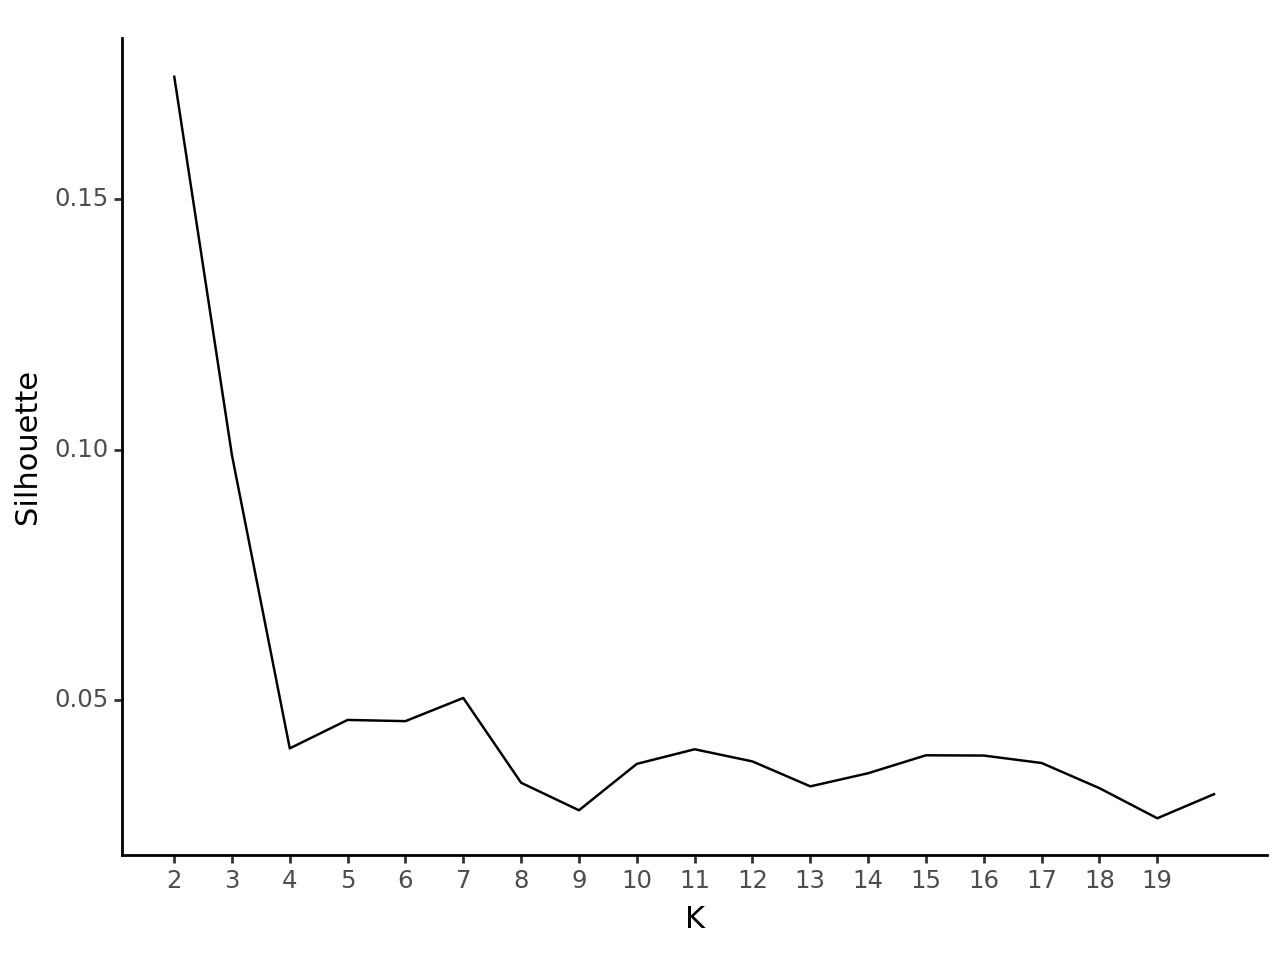

<Figure Size: (640 x 480)>

In [14]:
from plotnine import ggplot, aes, geom_line, theme_classic, labs, scale_x_continuous

(
    ggplot(k_means_comp) +
    geom_line(aes(x='index', y='silhouette')) +
    theme_classic() +
    labs(x='K', y='Silhouette') +
    scale_x_continuous(breaks=k_means_comp.index+1)
    )

In [ ]:
# Examining the cluster groupings
kmeans_pred_2.pred_cluster.value_counts()

1    73785
0    12077
Name: pred_cluster, dtype: int64

*elbow*

In [15]:
# Creating a data frame for making a plot
d_plot = pd.DataFrame({'inertia':inertias},
             index=k_range
             ).reset_index()

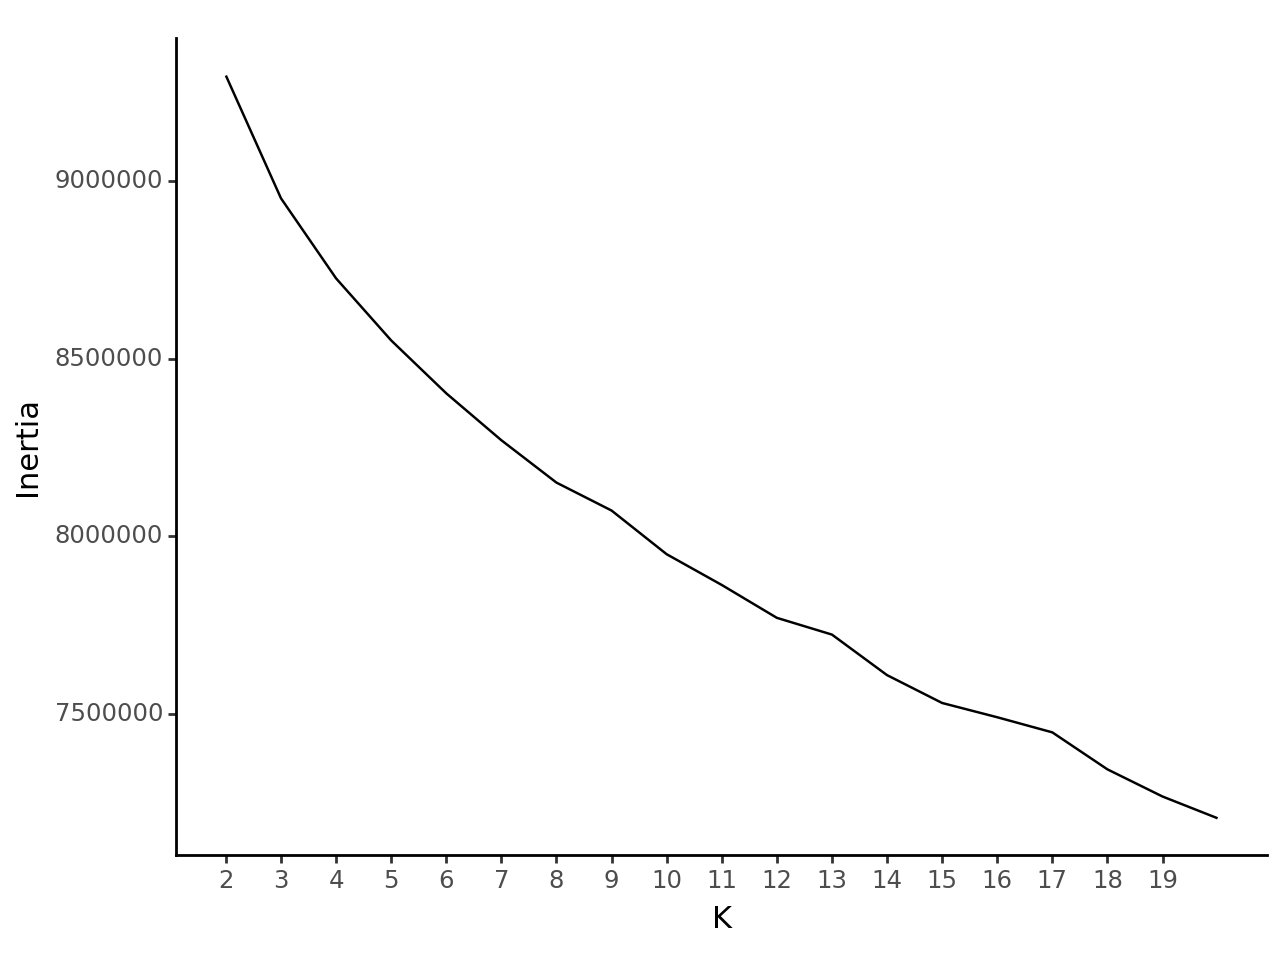

<Figure Size: (640 x 480)>

In [16]:
(
    ggplot(d_plot) +
    geom_line(aes(x='index', y='inertia')) +
    theme_classic() +
    labs(x='K', y='Inertia') +
    scale_x_continuous(breaks=d_plot.index+1)
    )

Analysing K-Means with 2 clusters

In [ ]:
# There appears to be an elbow around a value of 2. We can refit a model with this value and see what the groups look like
kmeans_2 = KMeans(n_clusters=2, n_init=20, random_state=0)

# Fitting and predicting in one line
y_pred_2 = kmeans_2.fit_predict(X)

# Storing the predictions in a dataframe to work with
kmeans_pred_2 = pd.DataFrame(
    {'cluster': y_pred_2},
    index=emicron.index
)

In [18]:
emicron

,DIRECTORIO,SECUENCIA_P,SECUENCIA_ENCUESTA,COD_DEPTO,CLASE_TE,P35,P241,P3031,P3033,P3034,...,P1906S1,P1906S2,P1906S3,P1906S4,P1906S5,P1906S6,P1906S7,P1906S8,Campesina,urban
0,5000001,1,2,8,1,2,61,2,2,96,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,0
1,5000003,1,1,8,1,1,44,2,2,96,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,0
2,5000003,1,2,8,1,2,37,2,2,180,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,9.0,0
3,5000007,1,1,8,1,2,36,1,2,36,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,0
4,5000008,1,1,8,1,1,60,2,2,120,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80748,7277027,1,4,66,1,1,74,2,2,380,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,1
80749,7277028,1,1,66,1,2,52,1,1,120,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,1
80750,7277029,1,1,66,1,1,63,2,2,420,...,4.0,4.0,4.0,4.0,4.0,4.0,4.0,4.0,0.0,1
80751,7277065,1,1,25,2,1,39,1,2,252,...,4.0,4.0,4.0,2.0,4.0,4.0,3.0,4.0,1.0,0


#Analysing the clusters

In [29]:
emicron['cluster'] = kmeans_pred_elbow['cluster']

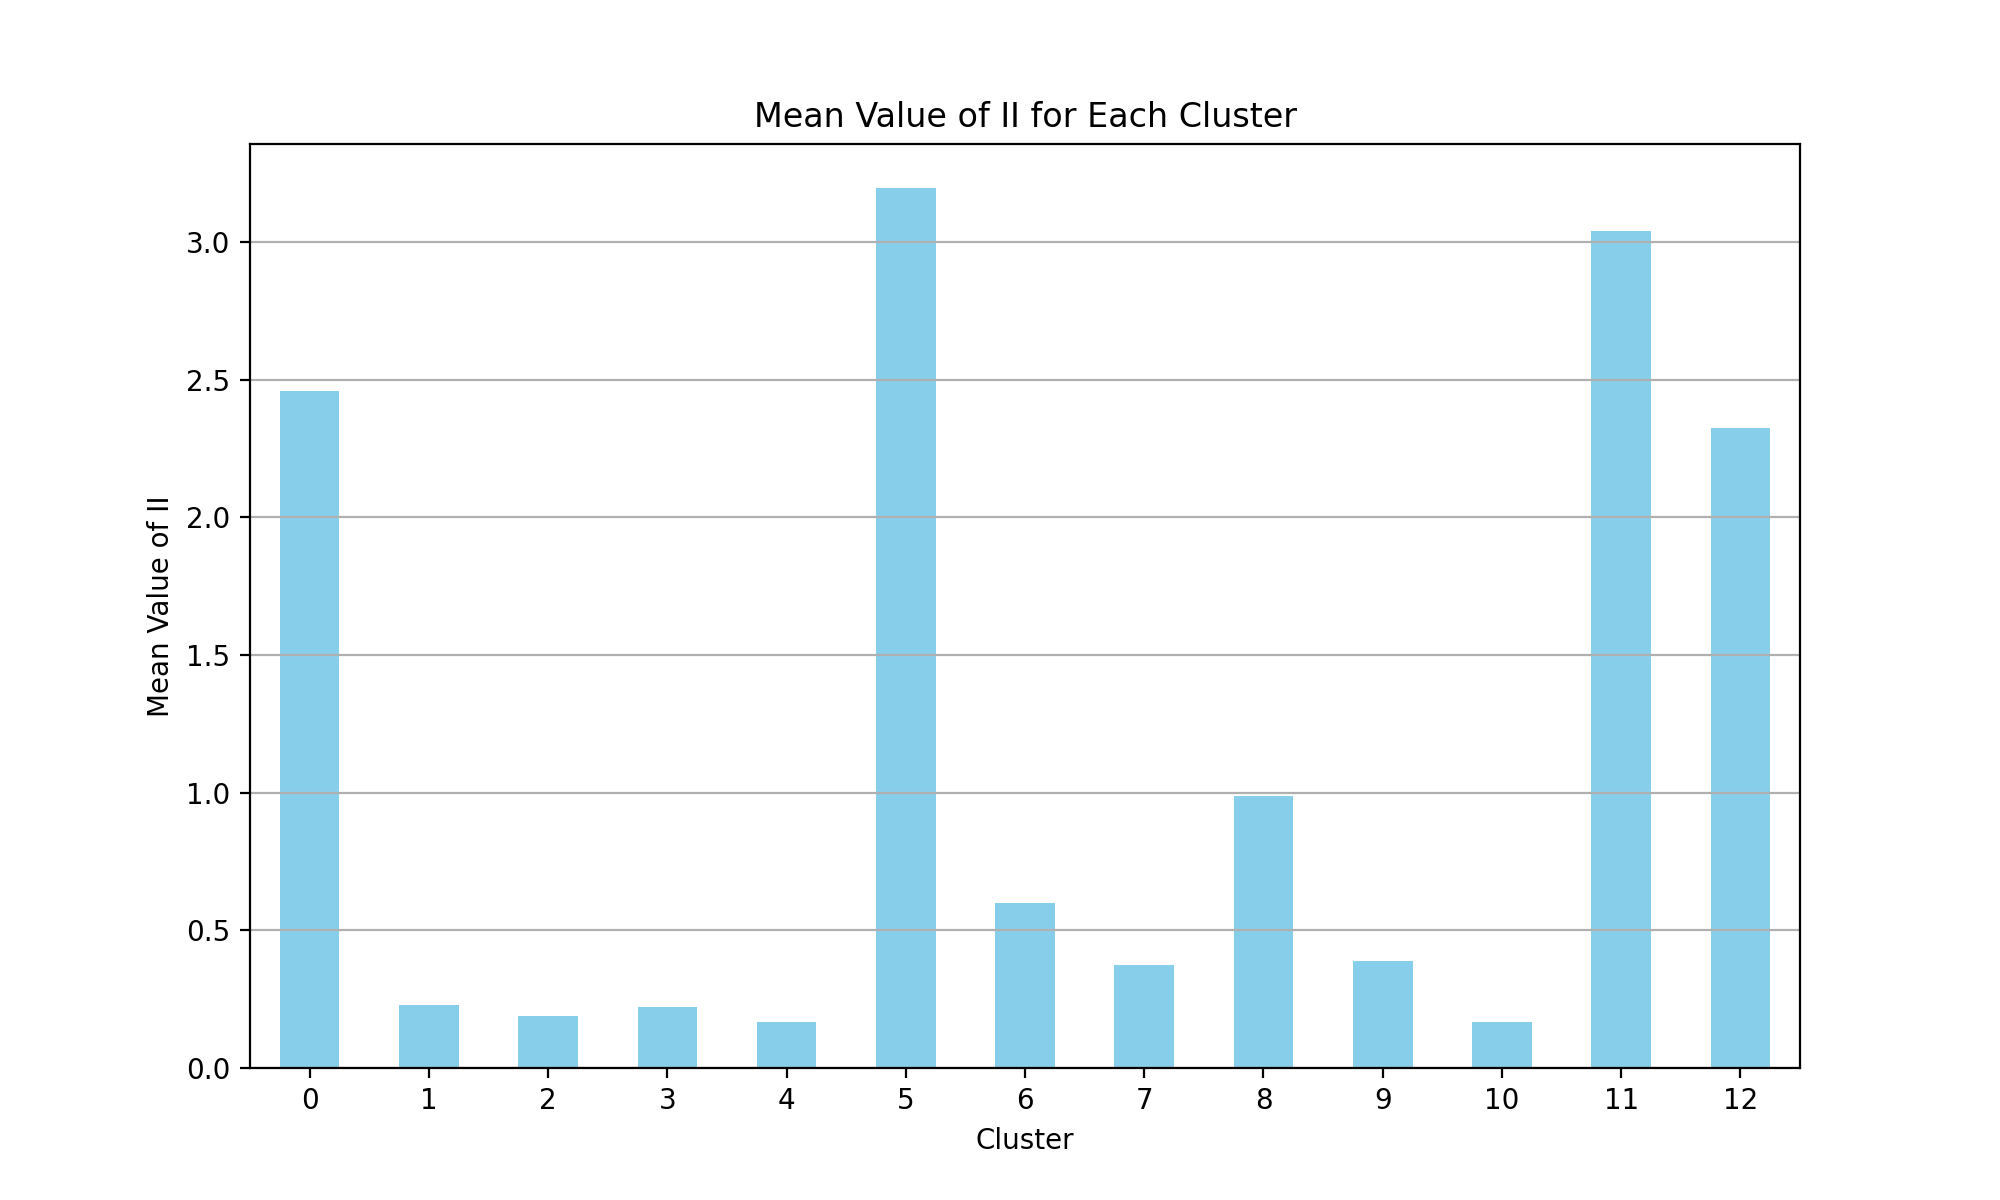

In [30]:
import matplotlib.pyplot as plt

# Assuming 'emicron' DataFrame contains the 'cluster' and 'II' columns

# Group by 'cluster' and calculate the mean of 'II' for each cluster
cluster_means = emicron.groupby('cluster')['II'].mean()

# Plotting the mean values
plt.figure(figsize=(10, 6))
cluster_means.plot(kind='bar', color='skyblue')
plt.xlabel('Cluster')
plt.ylabel('Mean Value of II')
plt.title('Mean Value of II for Each Cluster')
plt.xticks(rotation=0)  # Rotate x-axis labels if needed
plt.grid(axis='y')  # Add gridlines to y-axis
plt.show()

In [ ]:
# Get cluster centroids
cluster_0 = emicron[emicron['cluster'] == 0]
cluster_0

In [ ]:
cluster_1 = emicron[emicron['cluster'] == 1]

*monthly compensation of all workers*

In [ ]:
cluster_0['REMUNERACION_TOTAL'].mean()

41644.49033260209

In [ ]:
cluster_1['REMUNERACION_TOTAL'].mean()

1193141.4889744206

*registered in Chamber of Commerce?*

In [ ]:
cluster_0['P1055'].mean()

1.9802155577659386

In [ ]:
cluster_1['P1055'].mean()

1.3511346323470452

*Sales last month*

In [ ]:
print(cluster_0['VENTAS_MES_ANTERIOR'].mean())
print(cluster_1['VENTAS_MES_ANTERIOR'].mean())

1481011.1945470152
8756862.865127094


*Registered at RUT*

In [ ]:
print(cluster_0['P1633'].mean())
print(cluster_1['P1633'].mean())

1.8804349307135753
1.1080105845561703


*What financial register is used. val 3 and 5 would be informal*

Axes(0.125,0.11;0.775x0.77)


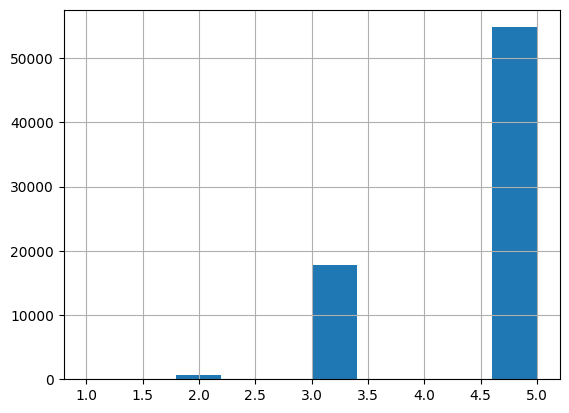

In [ ]:
print(cluster_0['P640'].hist())

Axes(0.125,0.11;0.775x0.77)


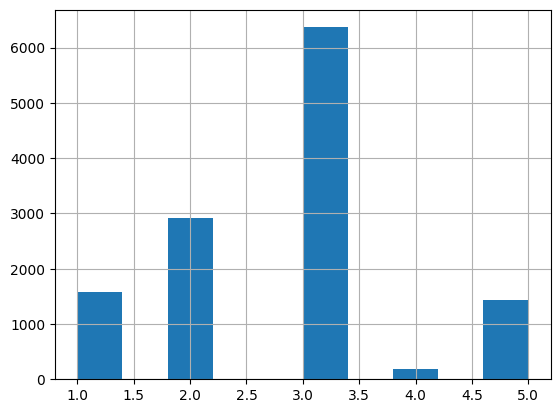

In [ ]:
print(cluster_1['P640'].hist())

*how many people work in the business*

In [ ]:
print(cluster_0['P3091'].mean())
print(cluster_1['P3091'].mean())

1.1450859097164503
2.2246010744928233


In [ ]:
print(cluster_1['P3091'].hist())

NameError: name 'cluster_1' is not defined

*whether your are a business owner (1) or a freelancer (2)*

In [ ]:
print(cluster_0['P3033'].mean())
print(cluster_1['P3033'].mean())

1.9578422422367865
1.5505572929195734


*average monthly consumption*

In [ ]:
print(cluster_0['CONSUMO_INTERMEDIO'].mean())
print(cluster_1['CONSUMO_INTERMEDIO'].mean())

795214.2379447072
5955338.625531233


*does the business have a commercial name? 1 yes 2 no*

Axes(0.125,0.11;0.775x0.77)


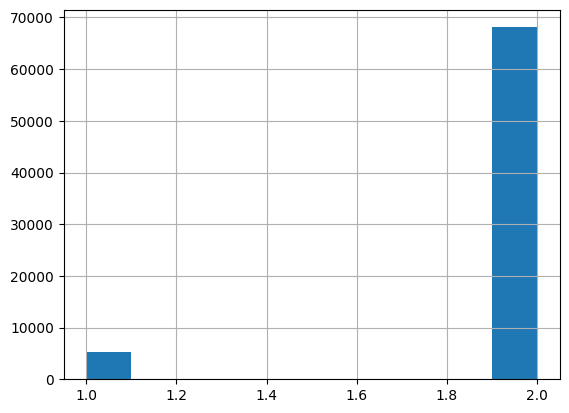

In [ ]:
print(cluster_0['P3035'].hist())

Axes(0.125,0.11;0.775x0.77)


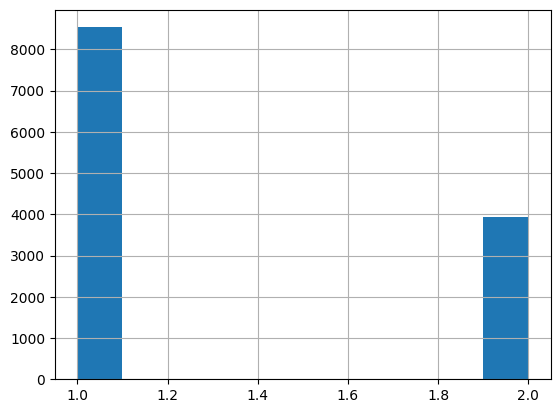

In [ ]:
print(cluster_1['P3035'].hist())

*social benefits paid per month*

In [ ]:
print(cluster_0['PRESTACIONES'].mean())
print(cluster_1['PRESTACIONES'].mean())

10107.090515185786
337253.5728490097


*if anyone helps in the business*

Axes(0.125,0.11;0.775x0.77)


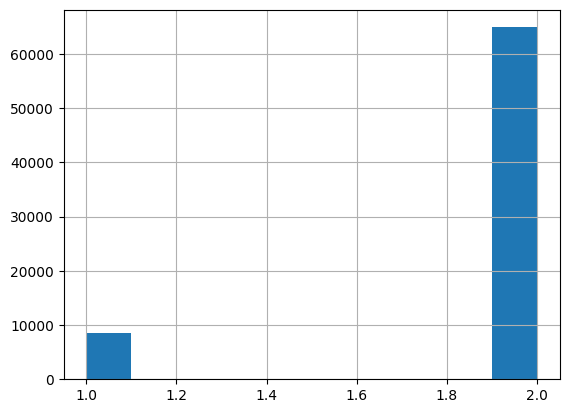

In [ ]:
print(cluster_0['P3031'].hist())

Axes(0.125,0.11;0.775x0.77)


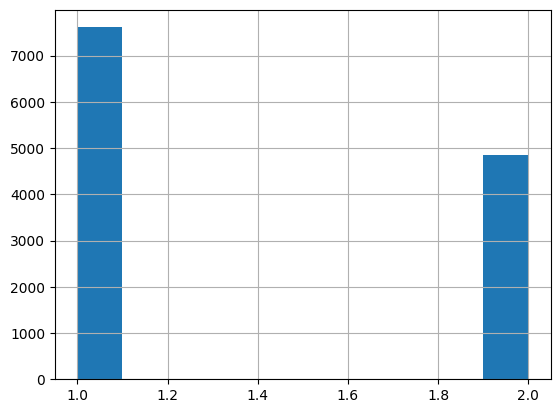

In [ ]:
print(cluster_1['P3031'].hist())

*does the business use technological devices?*

Axes(0.125,0.11;0.775x0.77)


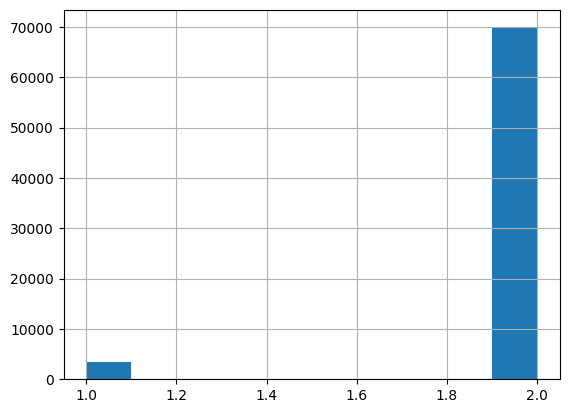

In [ ]:
print(cluster_0['P4001'].hist())

Axes(0.125,0.11;0.775x0.77)


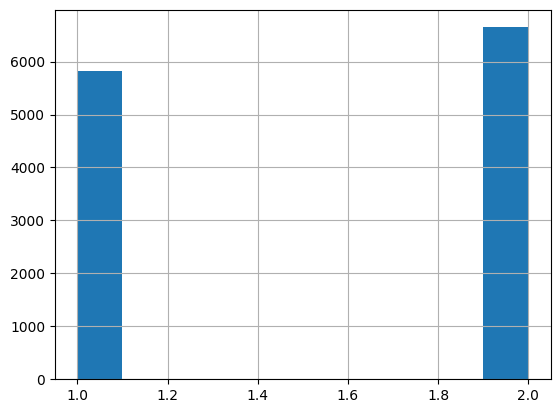

In [ ]:
print(cluster_1['P4001'].hist())

*costs last month*

In [ ]:
print(cluster_0['COSTOS_MES_ANTERIOR'].mean())
print(cluster_1['COSTOS_MES_ANTERIOR'].mean())

606433.5543322751
4655792.3489696095


*have paid ARL?*

Axes(0.125,0.11;0.775x0.77)


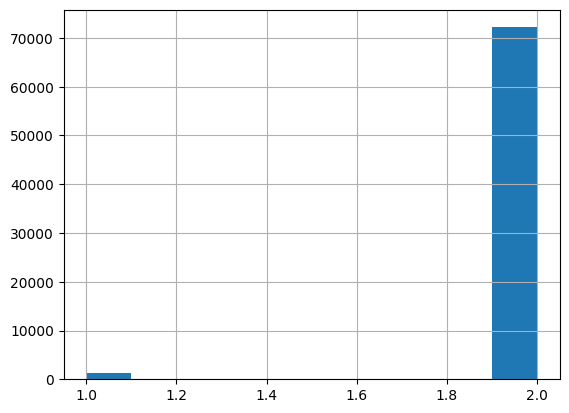

In [ ]:
print(cluster_0['P3090'].hist())

Axes(0.125,0.11;0.775x0.77)


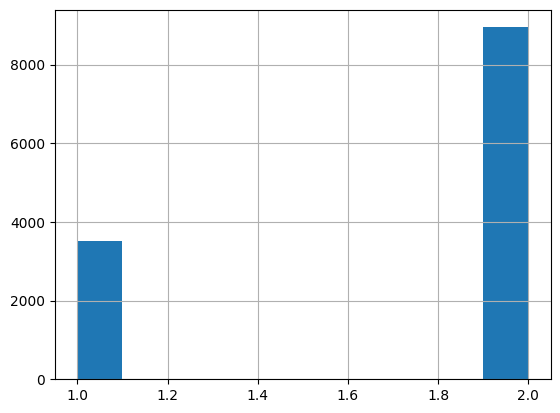

In [ ]:
print(cluster_1['P3090'].hist())

*does the business have internet?*

Axes(0.125,0.11;0.775x0.77)


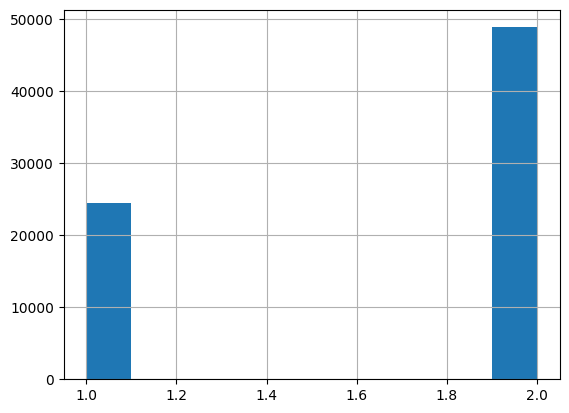

In [ ]:
print(cluster_0['P2524'].hist())

Axes(0.125,0.11;0.775x0.77)


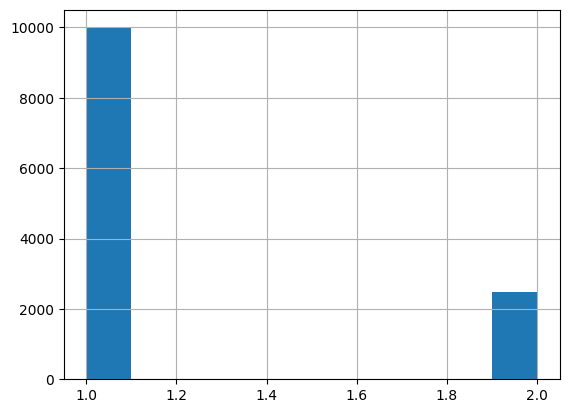

In [ ]:
print(cluster_1['P2524'].hist())

*average monthly sales*

In [ ]:
print(cluster_0['P3072'].mean())
print(cluster_1['P3072'].mean())

646352.363423308
1858131.72095261


*monthly costs*

In [ ]:
print(cluster_0['GASTOS_MES'].mean())
print(cluster_1['GASTOS_MES'].mean())

188336.93313894075
1286139.1311041617


*do you have email?*

Axes(0.125,0.11;0.775x0.77)


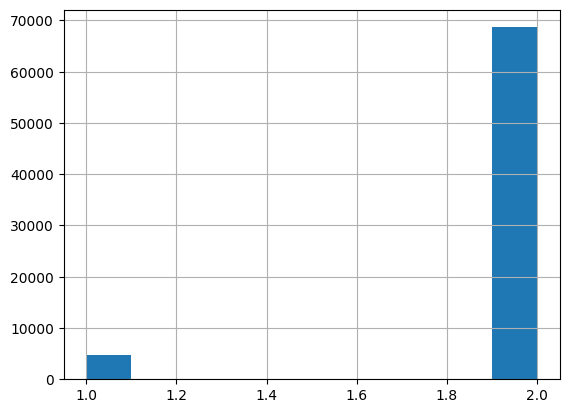

In [ ]:
print(cluster_0['P3000'].hist())

Axes(0.125,0.11;0.775x0.77)


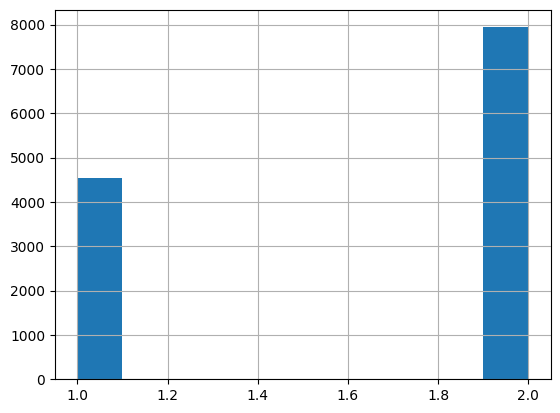

In [ ]:
print(cluster_1['P3000'].hist())

*social network?*

Axes(0.125,0.11;0.775x0.77)


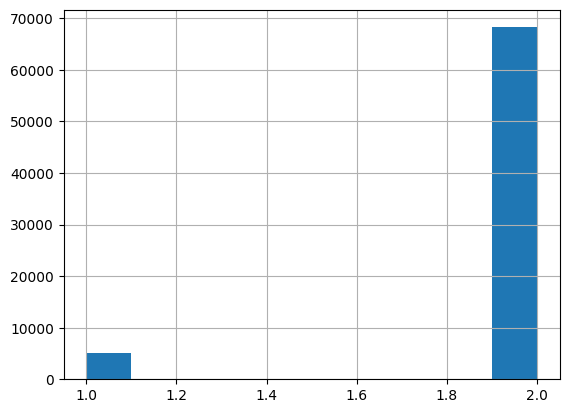

In [ ]:
print(cluster_0['P1559'].hist())

Axes(0.125,0.11;0.775x0.77)


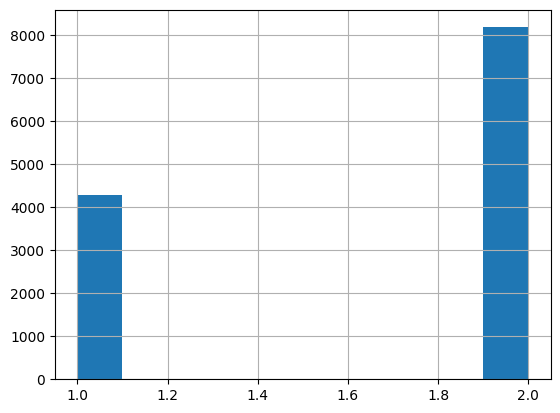

In [ ]:
print(cluster_1['P1559'].hist())

*do you have a telephone*

Axes(0.125,0.11;0.775x0.77)


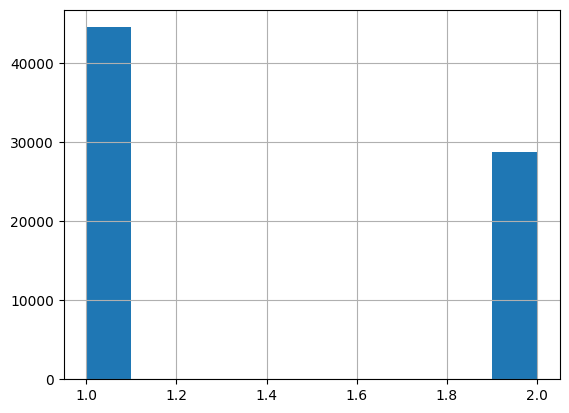

In [ ]:
print(cluster_0['P976'].hist())

Axes(0.125,0.11;0.775x0.77)


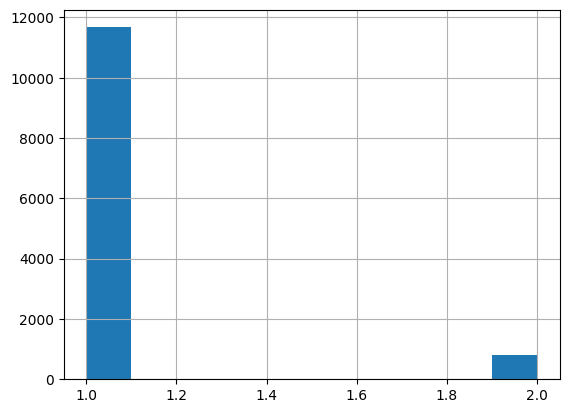

In [ ]:
print(cluster_1['P976'].hist())

*do you pay SENA or ICBF*

Axes(0.125,0.11;0.775x0.77)


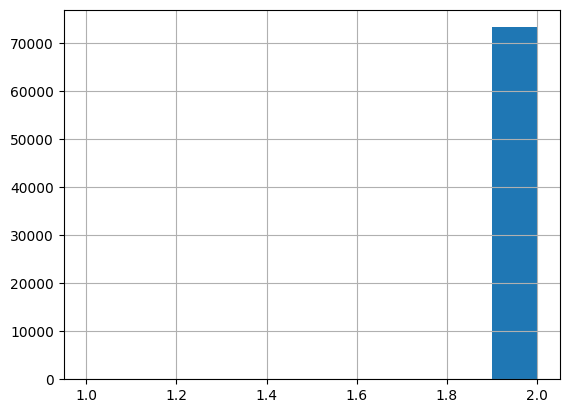

In [ ]:
print(cluster_0['P2989'].hist())

Axes(0.125,0.11;0.775x0.77)


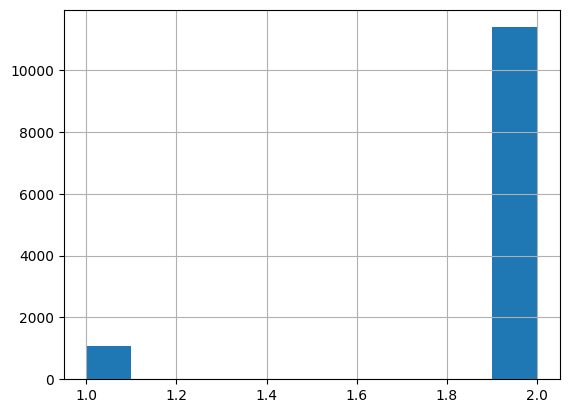

In [ ]:
print(cluster_1['P2989'].hist())

*did you pay healthcare or pension last month?*

Axes(0.125,0.11;0.775x0.77)


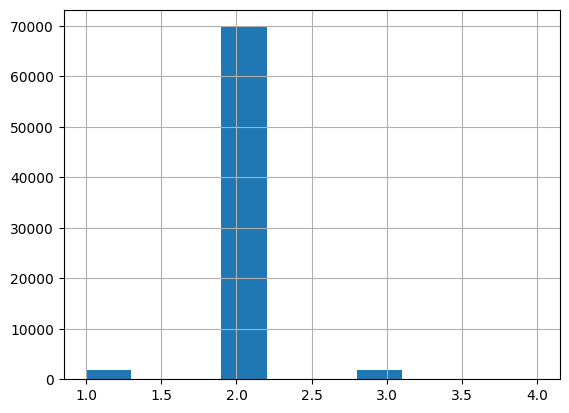

In [ ]:
print(cluster_0['P3088'].hist())

Axes(0.125,0.11;0.775x0.77)


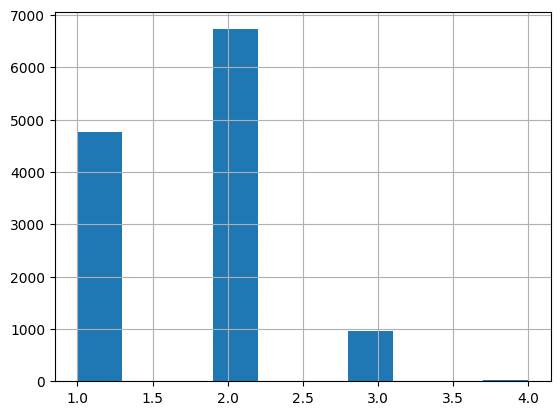

In [ ]:
print(cluster_1['P3088'].hist())

*added value monthly*

In [ ]:
print(cluster_0['VALOR_AGREGADO'].mean())
print(cluster_1['VALOR_AGREGADO'].mean())

685796.9566023082
2801524.2395958626


*which industrial category? 12*

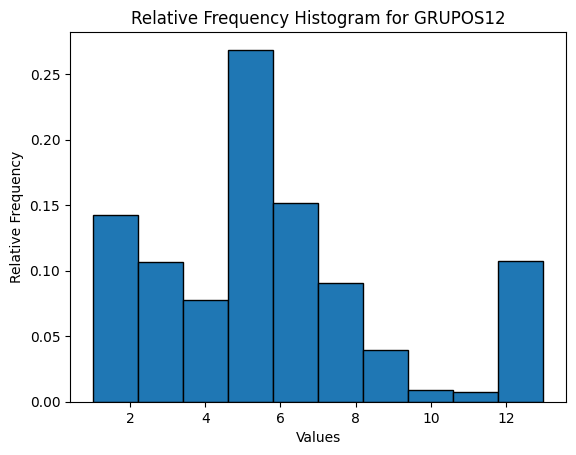

In [ ]:
# Create the relative frequency histogram
plt.hist(cluster_0['GRUPOS12'], edgecolor='black', weights=np.ones_like(cluster_0['GRUPOS12']) / len(cluster_0['GRUPOS12']))

# Customize labels and title
plt.xlabel('Values')
plt.ylabel('Relative Frequency')
plt.title('Relative Frequency Histogram for GRUPOS12')

# Show the plot
plt.show()

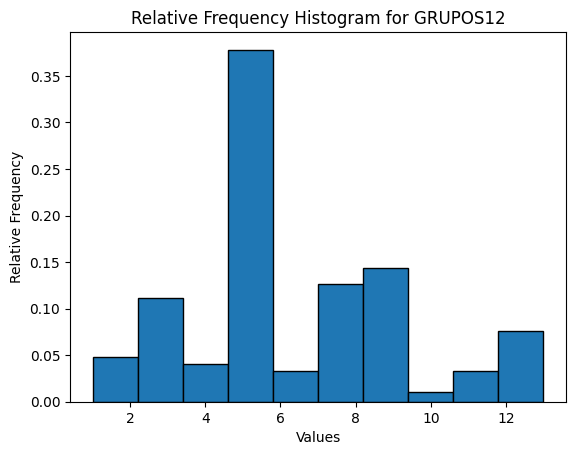

In [ ]:
# Create the relative frequency histogram
plt.hist(cluster_1['GRUPOS12'], edgecolor='black', weights=np.ones_like(cluster_1['GRUPOS12']) / len(cluster_1['GRUPOS12']))

# Customize labels and title
plt.xlabel('Values')
plt.ylabel('Relative Frequency')
plt.title('Relative Frequency Histogram for GRUPOS12')

# Show the plot
plt.show()

*which industrial category? 4*

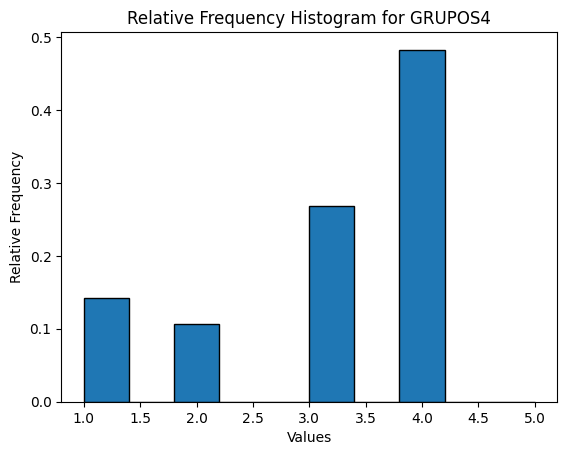

In [ ]:
# Create the relative frequency histogram
plt.hist(cluster_0['GRUPOS4'], edgecolor='black', weights=np.ones_like(cluster_0['GRUPOS4']) / len(cluster_0['GRUPOS4']))

# Customize labels and title
plt.xlabel('Values')
plt.ylabel('Relative Frequency')
plt.title('Relative Frequency Histogram for GRUPOS4')

# Show the plot
plt.show()

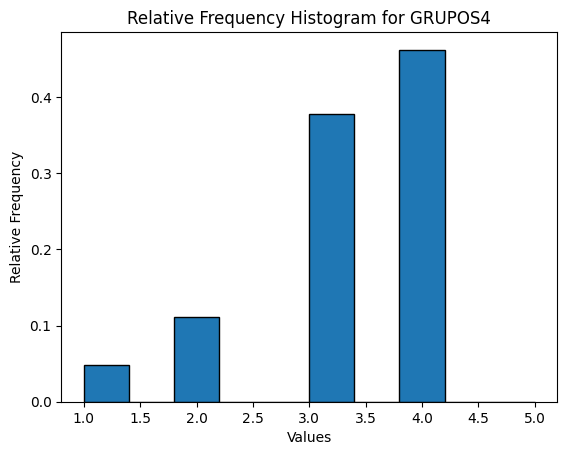

In [ ]:
# Create the relative frequency histogram
plt.hist(cluster_1['GRUPOS4'], edgecolor='black', weights=np.ones_like(cluster_1['GRUPOS4']) / len(cluster_1['GRUPOS4']))

# Customize labels and title
plt.xlabel('Values')
plt.ylabel('Relative Frequency')
plt.title('Relative Frequency Histogram for GRUPOS4')

# Show the plot
plt.show()

*Municipal Head Offices*

*Populated Centres and Dispersed Rural Areas*

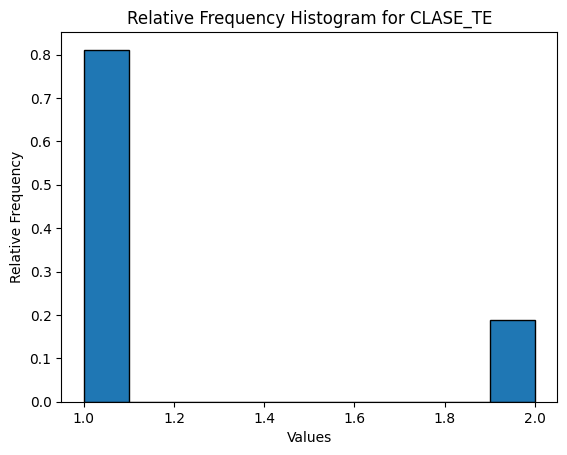

In [ ]:
# Create the relative frequency histogram
plt.hist(cluster_0['CLASE_TE'], edgecolor='black', weights=np.ones_like(cluster_0['CLASE_TE']) / len(cluster_0['CLASE_TE']))

# Customize labels and title
plt.xlabel('Values')
plt.ylabel('Relative Frequency')
plt.title('Relative Frequency Histogram for CLASE_TE')

# Show the plot
plt.show()

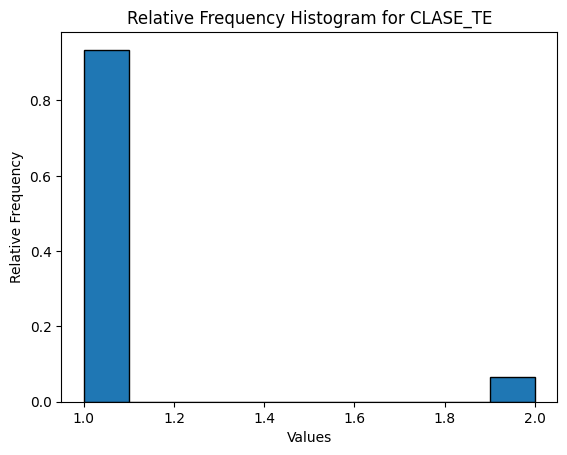

In [ ]:
# Create the relative frequency histogram
plt.hist(cluster_1['CLASE_TE'], edgecolor='black', weights=np.ones_like(cluster_1['CLASE_TE']) / len(cluster_1['CLASE_TE']))

# Customize labels and title
plt.xlabel('Values')
plt.ylabel('Relative Frequency')
plt.title('Relative Frequency Histogram for CLASE_TE')

# Show the plot
plt.show()

*establishment of business*

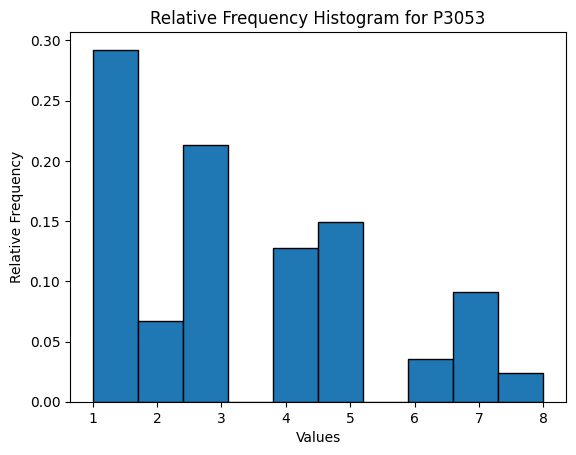

In [ ]:
# Create the relative frequency histogram
plt.hist(cluster_0['P3053'], edgecolor='black', weights=np.ones_like(cluster_0['P3053']) / len(cluster_0['P3053']))

# Customize labels and title
plt.xlabel('Values')
plt.ylabel('Relative Frequency')
plt.title('Relative Frequency Histogram for P3053')

# Show the plot
plt.show()

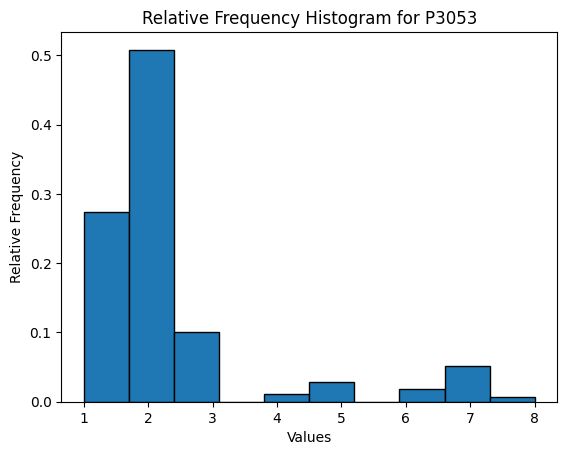

In [ ]:
# Create the relative frequency histogram
plt.hist(cluster_1['P3053'], edgecolor='black', weights=np.ones_like(cluster_1['P3053']) / len(cluster_1['P3053']))

# Customize labels and title
plt.xlabel('Values')
plt.ylabel('Relative Frequency')
plt.title('Relative Frequency Histogram for P3053')

# Show the plot
plt.show()

*how many months have you been working in this establishment?*

In [ ]:
print(cluster_0['P3034'].mean())
print(cluster_1['P3034'].mean())

129.9429766592634
135.3875390906904


*How much time has this business working?*

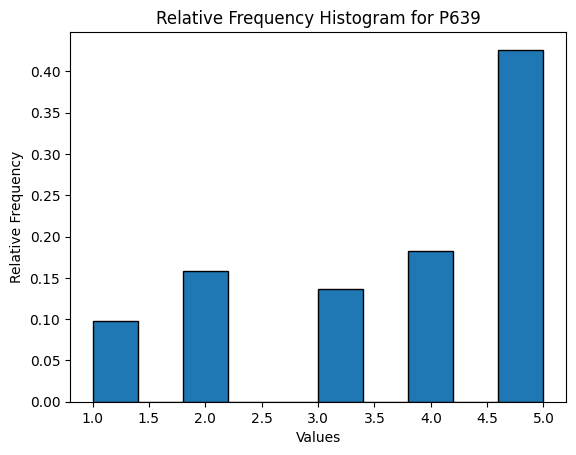

In [ ]:
# Create the relative frequency histogram
plt.hist(cluster_0['P639'], edgecolor='black', weights=np.ones_like(cluster_0['P639']) / len(cluster_0['P639']))

# Customize labels and title
plt.xlabel('Values')
plt.ylabel('Relative Frequency')
plt.title('Relative Frequency Histogram for P639')

# Show the plot
plt.show()

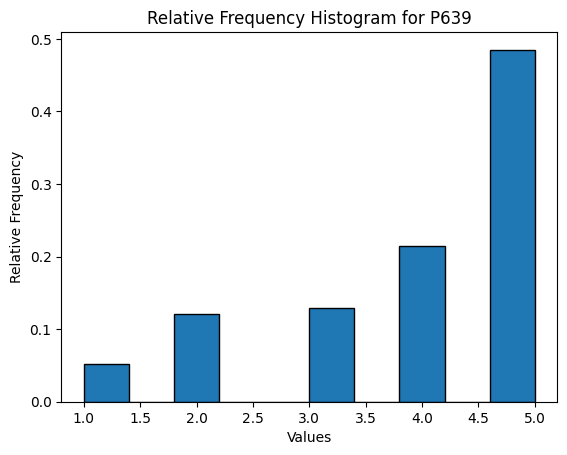

In [ ]:
# Create the relative frequency histogram
plt.hist(cluster_1['P639'], edgecolor='black', weights=np.ones_like(cluster_1['P639']) / len(cluster_1['P639']))

# Customize labels and title
plt.xlabel('Values')
plt.ylabel('Relative Frequency')
plt.title('Relative Frequency Histogram for P639')

# Show the plot
plt.show()

*age of the owner*

In [ ]:
print(cluster_0['P241'].mean())
print(cluster_1['P241'].mean())

45.72634246705999
45.79007296928875


*urban vs rural*

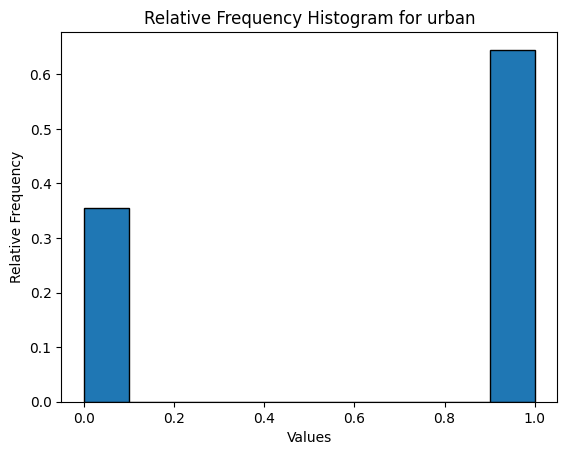

In [ ]:
# Create the relative frequency histogram
plt.hist(cluster_0['urban'], edgecolor='black', weights=np.ones_like(cluster_0['urban']) / len(cluster_0['urban']))

# Customize labels and title
plt.xlabel('Values')
plt.ylabel('Relative Frequency')
plt.title('Relative Frequency Histogram for urban')

# Show the plot
plt.show()

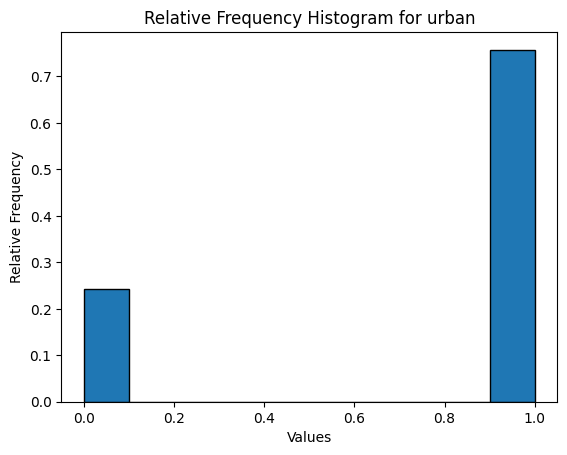

In [ ]:
# Create the relative frequency histogram
plt.hist(cluster_1['urban'], edgecolor='black', weights=np.ones_like(cluster_1['urban']) / len(cluster_1['urban']))

# Customize labels and title
plt.xlabel('Values')
plt.ylabel('Relative Frequency')
plt.title('Relative Frequency Histogram for urban')

# Show the plot
plt.show()

*geographical location*

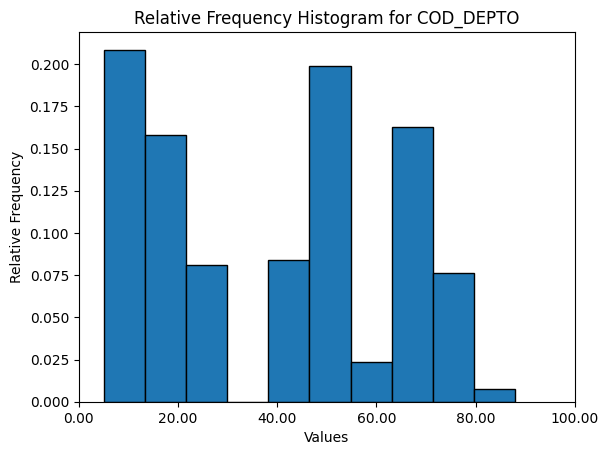

In [ ]:
# Create the relative frequency histogram
plt.hist(cluster_0['COD_DEPTO'], edgecolor='black', weights=np.ones_like(cluster_0['COD_DEPTO']) / len(cluster_0['COD_DEPTO']))

# Customize labels and title
plt.xlabel('Values')
plt.ylabel('Relative Frequency')
plt.title('Relative Frequency Histogram for COD_DEPTO')

# Manually set x-axis tick positions and labels
tick_values, _ = plt.xticks()
plt.xticks(tick_values, [f'{value:.2f}' for value in tick_values])  # Format the labels as desired

# Show the plot
plt.show()

In [ ]:
(cluster_0['COD_DEPTO'].value_counts()/len(cluster_0['COD_DEPTO'])).sort_values(ascending=0)

70    0.080391
13    0.074573
47    0.071943
8     0.067719
52    0.063346
44    0.056778
5     0.052581
76    0.051777
68    0.051600
23    0.043820
18    0.040318
20    0.037975
54    0.033083
50    0.030644
66    0.030481
17    0.030344
27    0.027497
41    0.027183
19    0.026883
73    0.024390
63    0.023354
15    0.022305
11    0.013653
25    0.009770
88    0.007589
Name: COD_DEPTO, dtype: float64

In [ ]:
(cluster_1['COD_DEPTO'].value_counts()/len(cluster_0['COD_DEPTO'])).sort_values(ascending=0)

5     0.013585
17    0.011582
68    0.011337
50    0.010560
76    0.010383
15    0.010137
52    0.009156
66    0.008530
73    0.008080
8     0.007903
11    0.007848
19    0.007385
41    0.007249
54    0.006472
63    0.006254
20    0.005437
47    0.004823
18    0.004769
25    0.003747
88    0.003638
23    0.002930
44    0.002507
13    0.002384
70    0.001812
27    0.001417
Name: COD_DEPTO, dtype: float64

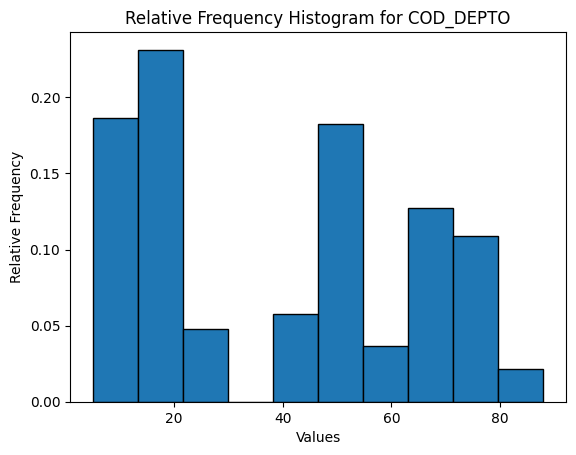

In [ ]:
# Create the relative frequency histogram
plt.hist(cluster_1['COD_DEPTO'], edgecolor='black', weights=np.ones_like(cluster_1['COD_DEPTO']) / len(cluster_1['COD_DEPTO']))

# Customize labels and title
plt.xlabel('Values')
plt.ylabel('Relative Frequency')
plt.title('Relative Frequency Histogram for COD_DEPTO')

# Show the plot
plt.show()